In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Custom Dataset class for loading route plot images
class RoutePlotsDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_name).convert("RGB")  # Convert to RGB
        
        if self.transform:
            image = self.transform(image)
        
        return image, self.image_files[idx]  # Return image and filename

# Define any transformations, if needed
transform = transforms.Compose([
    #transforms.Resize((128, 128)),  # Resize all images to 128x128 (optional)
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

# Create dataset from route_plots folder
folder_path = 'route_plots'
route_dataset = RoutePlotsDataset(folder_path, transform=transform)

# Create DataLoader to iterate over the dataset
route_loader = DataLoader(route_dataset, batch_size=32, shuffle=True, num_workers=0)

# Example: Loop through DataLoader and print image tensor shapes
#for images, filenames in route_loader:
    #print(f"Batch of images shape: {images.shape}")
    #print(f"Filenames: {filenames}")


In [2]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Function to display 4 random unique images
def show_random_images(dataset, num_images=4):
    # Randomly select unique indices
    random_indices = random.sample(range(len(dataset)), num_images)
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for ax, idx in zip(axes, random_indices):
        # Load the image and filename using the selected index
        image, filename = dataset[idx]
        
        # If the image is a tensor, convert it to a numpy array
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()  # Change the dimension order
        
        # Unnormalize the image (assuming it's been normalized)
        image = (image * 0.5 + 0.5).clip(0, 1)
        
        ax.imshow(image)
        ax.set_title(f"{filename}")
        ax.axis("off")
    
    plt.show()


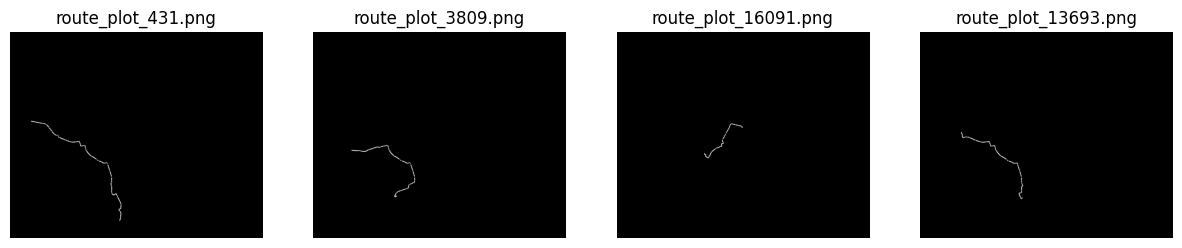

In [3]:
# Display 4 random images from the dataset
show_random_images(route_dataset, num_images=4)

In [4]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import os
from glob import glob
from PIL import Image  # Make sure to import this for image loading


In [5]:
class RoutePlotsDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_name).convert("L")  # Convert to grayscale
        
        if self.transform:
            image = self.transform(image)
        
        return image, self.image_files[idx]  # Return image and filename


In [6]:
image_size = 600
# Create a transform to resize the images to 28x28
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize to 28x28
    transforms.ToTensor(),  # Convert to Tensor
])

# Load your dataset from the folder
folder_path = 'route_plots_5000'  # Adjust to your folder
route_dataset = RoutePlotsDataset(folder_path, transform=transform)

# Create DataLoader
batch_size = 10
train_loader = DataLoader(dataset=route_dataset, batch_size=batch_size, shuffle=True)

data_dim = image_size*image_size

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
class VAE(nn.Module):

    def __init__(self, input_dim=data_dim, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()
        
        self.device = device #newly added

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)
        
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.decode(z)  
        return x_hat, mean, log_var

In [9]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [10]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [11]:
def train(model, optimizer, epochs, device, x_dim=data_dim):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

In [12]:
# Train the model
train(model, optimizer, epochs=30, device=device) #116

	Epoch 1 	Average Loss:  5866.403998622244
	Epoch 2 	Average Loss:  1667.71531050382
	Epoch 3 	Average Loss:  1561.1735676430987
	Epoch 4 	Average Loss:  1501.55075972257
	Epoch 5 	Average Loss:  1448.8354286698398
	Epoch 6 	Average Loss:  1417.557234977768
	Epoch 7 	Average Loss:  1390.3082786667085
	Epoch 8 	Average Loss:  1369.7633548346694
	Epoch 9 	Average Loss:  1346.5988426070892
	Epoch 10 	Average Loss:  1333.0663966605084
	Epoch 11 	Average Loss:  1311.3755918086172
	Epoch 12 	Average Loss:  1301.4082387431113
	Epoch 13 	Average Loss:  1289.1125452076028
	Epoch 14 	Average Loss:  1278.1102079158316
	Epoch 15 	Average Loss:  1266.5209066570642
	Epoch 16 	Average Loss:  1254.3910649423847
	Epoch 17 	Average Loss:  1242.1122966636399
	Epoch 18 	Average Loss:  1239.7413463646042
	Epoch 19 	Average Loss:  1224.3397001033316
	Epoch 20 	Average Loss:  1212.1032490762775
	Epoch 21 	Average Loss:  1207.9577422422972
	Epoch 22 	Average Loss:  1201.348590344752
	Epoch 23 	Average Loss:  

5688206.4599609375

In [13]:
def calculate_similarity(original, reconstructed, threshold=0.03):
    
    # Convert tensors to numpy arrays
    original_np = original.cpu().numpy()
    reconstructed_np = reconstructed.cpu().numpy()

    # Calculate overall pixel similarity
    total_pixels = original_np.size
    pixel_diff = np.abs(original_np - reconstructed_np)
    num_similar_pixels = np.sum(pixel_diff < threshold)
    overall_similarity = (num_similar_pixels / total_pixels) * 100

    # Calculate white pixel similarity
    white_pixel_mask = original_np > threshold
    original_white_pixels = original_np[white_pixel_mask]
    reconstructed_white_pixels = reconstructed_np[white_pixel_mask]
    white_pixel_diff = np.abs(original_white_pixels - reconstructed_white_pixels)
    num_similar_white_pixels = np.sum(white_pixel_diff < threshold)
    total_white_pixels = len(original_white_pixels)

    if total_white_pixels == 0:
        white_pixel_similarity = 0.0  # If no white pixels, return 0 similarity
    else:
        white_pixel_similarity = (num_similar_white_pixels / total_white_pixels) * 100

    return overall_similarity, white_pixel_similarity

def visualize_pixel_reconstructions(model, dataset, num_images=10, threshold=0.03):
    model.eval()  # Set the model to evaluation mode

    # Select random images from the dataset
    indices = random.sample(range(len(dataset)), num_images)
    original_images = []
    reconstructed_images = []
    overall_similarity_scores = []
    white_pixel_similarity_scores = []

    for idx in indices:
        # Get image and filename from the dataset
        img, _ = dataset[idx]

        # Prepare the image for the model
        img = img.view(1, -1).to(device)  # Flatten the image for the VAE

        # Pass the image through the VAE
        with torch.no_grad():  # Disable gradient computation
            reconstructed_img, _, _ = model(img)

        # Reshape the original and reconstructed images back to 2D
        original_img = img.view(image_size, image_size).cpu()
        reconstructed_img = reconstructed_img.view(image_size, image_size).cpu()

        # Calculate overall and white pixel similarity
        overall_similarity, white_pixel_similarity = calculate_similarity(original_img, reconstructed_img, threshold)
        overall_similarity_scores.append(overall_similarity)
        white_pixel_similarity_scores.append(white_pixel_similarity)

        original_images.append(original_img)
        reconstructed_images.append(reconstructed_img)

    # Plot original and reconstructed images side by side with both similarity scores
    fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(8, num_images * 2))

    for i in range(num_images):
        # Plot original image
        axs[i, 0].imshow(original_images[i], cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 0].set_title(f'Original Image')

        # Plot reconstructed image with similarity scores
        axs[i, 1].imshow(reconstructed_images[i], cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].set_title(
            f'Reconstructed\nOverall: {overall_similarity_scores[i]:.2f}%\nWhite Pixels: {white_pixel_similarity_scores[i]:.2f}%'
        )

    plt.tight_layout()
    plt.show()


In [14]:
# Visualize and calculate both overall and white pixel similarity
#visualize_pixel_reconstructions(model, route_dataset, num_images=5, threshold=0.1)

In [15]:
import numpy as np
import torch

def threshold_white_pixels(reconstructed_img, threshold=0.03):
    """
    Removes pixels that are not white enough from a reconstructed image based on a threshold.

    Args:
        reconstructed_img (torch.Tensor or np.ndarray): The input reconstructed image (2D array).
        threshold (float): Threshold between 0 and 1 to consider a pixel as "white enough".

    Returns:
        np.ndarray: The processed image with only "white enough" pixels retained.
    """
    # Ensure the image is a NumPy array
    if isinstance(reconstructed_img, torch.Tensor):
        reconstructed_img = reconstructed_img.cpu().numpy()
    
    # Apply the threshold
    processed_img = np.where(reconstructed_img > threshold, reconstructed_img, 0.0)

    return processed_img


random adat ereménye környezetében generálni eredményt a látens térből
ezeket összehasonlitani az összes adattal az adathalmazból
kép a teamsen

# A generált út a térképen kiemelve (összegük)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


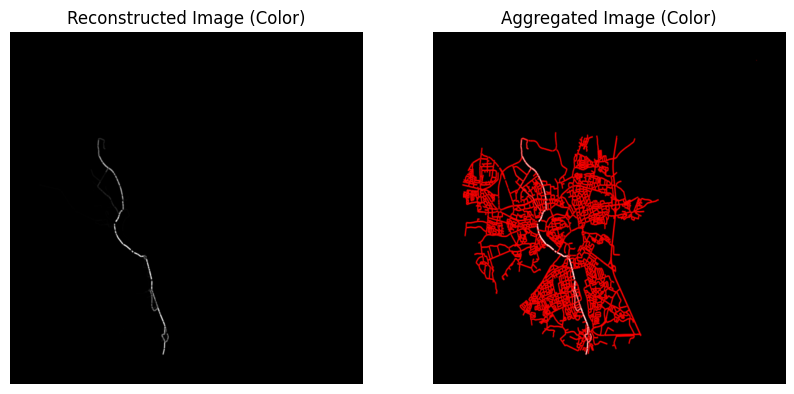

Aggregated image saved at aggregated_images\aggregated_image_5.png


In [16]:
# Load and prepare the map_plot image as a tensor
map_plot_path = 'map_plot/map_plot.png'

# Load the map_plot image in RGB (color)
map_plot_image = Image.open(map_plot_path).convert('RGB')  # Preserve color
map_plot_tensor = transforms.ToTensor()(map_plot_image)
map_plot_tensor = transforms.Resize((image_size, image_size))(map_plot_tensor)

from PIL import Image
import os

def plot_and_save_aggregated_image(model, dataset, map_plot_tensor, image_index=None, save_path='aggregated_images'):
    """
    Plot the reconstructed image and its multiplication with map_plot in color,
    then save the multiplied image to a specified folder.
    """
    model.eval()

    # Select a random index if not provided
    if image_index is None:
        image_index = random.randint(0, len(dataset) - 1)

    # Retrieve and preprocess the image
    img, _ = dataset[image_index]
    img = img.view(1, -1).to(device)

    # Reconstruct the image using the VAE
    with torch.no_grad():
        reconstructed_img, _, _ = model(img)

    # Reshape the reconstructed image to RGB
    reconstructed_img_np = reconstructed_img.view(image_size, image_size).cpu().numpy()
    reconstructed_img_rgb = np.stack([reconstructed_img_np] * 3, axis=-1)  # Duplicate channels for RGB

    # Convert the map_plot to a numpy array
    map_plot_np = map_plot_tensor.permute(1, 2, 0).cpu().numpy()

    # Multiply each channel independently
    multiplied_result = reconstructed_img_rgb + map_plot_np

    # Plot the reconstructed and multiplied images side-by-side in color
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Reconstructed Image in Color
    axes[0].imshow(reconstructed_img_rgb)
    axes[0].axis('off')
    axes[0].set_title("Reconstructed Image (Color)")

    # Multiplied Image in Color
    axes[1].imshow(multiplied_result)
    axes[1].axis('off')
    axes[1].set_title("Aggregated Image (Color)")

    plt.show()

    # Ensure the save directory exists
    os.makedirs(save_path, exist_ok=True)

    # Save the multiplied image
    multiplied_image = Image.fromarray((multiplied_result * 255).astype(np.uint8))
    multiplied_image_path = os.path.join(save_path, f'aggregated_image_{image_index}.png')
    multiplied_image.save(multiplied_image_path)
    print(f"Aggregated image saved at {multiplied_image_path}")

# Use the function
plot_and_save_aggregated_image(model, route_dataset, map_plot_tensor, image_index=5)

# Jövőhétre
- Veszek mintákat az adathalmazból és előállítom a recunstrukciót
- összehasonlítom a mintát és a rekonstrukcióját egy adott küszöbértékkel, ha mindkettöben van ugyanaz a pixel az adott küszöbb felett, akkor TP+1, ha nem, akkor FP+1
- TPR = TP/fehér pixel az eredetiben
- FPR = FP/nem fehér pixel az eredetiben
- ROC görbe = melyik az a küszöbérték, ahol az euklédeszi távolság minimális TPR = 1, FPR = 0 ponttól, ebből megvan a küszöbb, amit innentől mindenhol alkalmazhatok.

# A generált út és a térkép közös részei (szorzata)

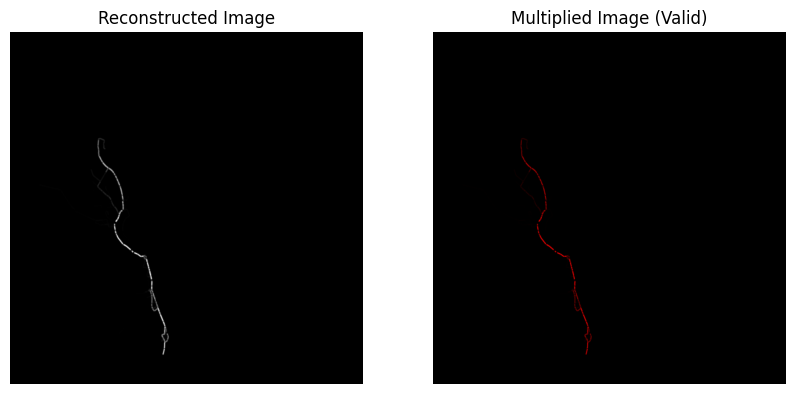

Multiplied image saved at multiplied_images\multiplied_image_5.png


In [17]:
from PIL import Image
import os

def plot_and_save_multiplied_image(model, dataset, map_plot_tensor, image_index=None, save_path='multiplied_images'):
    """
    Plot the reconstructed image and its multiplication with map_plot in color,
    then save the multiplied image to a specified folder.
    """
    model.eval()

    # Select a random index if not provided
    if image_index is None:
        image_index = random.randint(0, len(dataset) - 1)

    # Retrieve and preprocess the image
    img, _ = dataset[image_index]
    img = img.view(1, -1).to(device)

    # Reconstruct the image using the VAE
    with torch.no_grad():
        reconstructed_img, _, _ = model(img)

    # Reshape the reconstructed image to RGB
    reconstructed_img_np = reconstructed_img.view(image_size, image_size).cpu().numpy()
    reconstructed_img_rgb = np.stack([reconstructed_img_np] * 3, axis=-1)  # Duplicate channels for RGB

    # Convert the map_plot to a numpy array
    map_plot_np = map_plot_tensor.permute(1, 2, 0).cpu().numpy()

    # Multiply each channel independently
    multiplied_result = reconstructed_img_rgb * map_plot_np

    # Plot the reconstructed and multiplied images side-by-side in color
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Reconstructed Image in Color
    axes[0].imshow(reconstructed_img_rgb)
    axes[0].axis('off')
    axes[0].set_title("Reconstructed Image")

    # Multiplied Image in Color
    axes[1].imshow(multiplied_result)
    axes[1].axis('off')
    axes[1].set_title("Multiplied Image (Valid)")

    plt.show()

    # Ensure the save directory exists
    os.makedirs(save_path, exist_ok=True)

    # Save the multiplied image
    multiplied_image = Image.fromarray((multiplied_result * 255).astype(np.uint8))
    multiplied_image_path = os.path.join(save_path, f'multiplied_image_{image_index}.png')
    multiplied_image.save(multiplied_image_path)
    print(f"Multiplied image saved at {multiplied_image_path}")
    
    return multiplied_result

# Use the function
multiplied_result = plot_and_save_multiplied_image(model, route_dataset, map_plot_tensor, image_index=5)

# Validity, szorzat/eredeti pixelek száma

# Az eredeti és a rekonstruált út és a köztük levő különbség

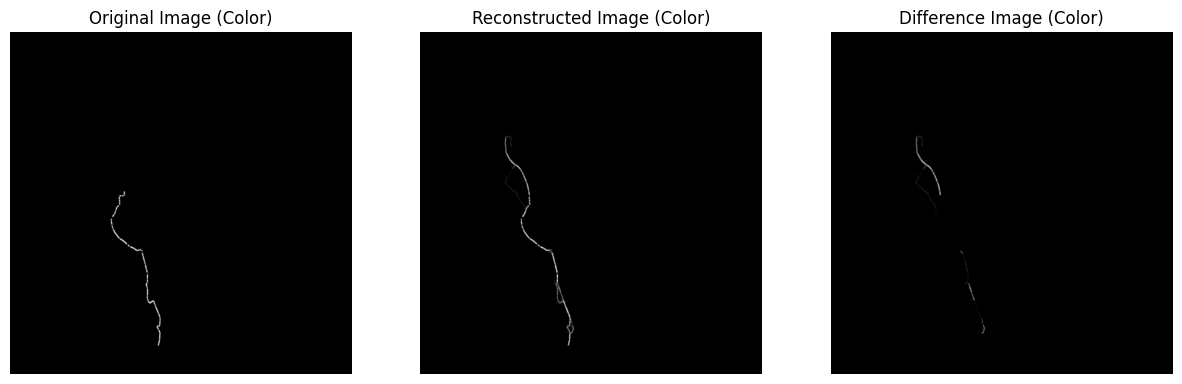

Difference image saved at difference_images\difference_image_5.png
Percentage of white pixels preserved: 71.40%


In [18]:
def plot_and_save_difference_image_with_metrics(model, dataset, map_plot_tensor, image_index=None, save_path='difference_images'):
    """
    Plot the original, reconstructed, and difference images in color,
    measure the numerical difference, and then save the difference image to a specified folder.
    """
    model.eval()

    # Select a random index if not provided
    if image_index is None:
        image_index = random.randint(0, len(dataset) - 1)

    # Retrieve and preprocess the image
    original_img, _ = dataset[image_index]
    original_img = original_img.view(1, -1).to(device)

    # Reconstruct the image using the VAE
    with torch.no_grad():
        reconstructed_img, _, _ = model(original_img)

    # Reshape the original and reconstructed images
    original_img_np = original_img.view(image_size, image_size).cpu().numpy()
    reconstructed_img_np = reconstructed_img.view(image_size, image_size).cpu().numpy()
    
    # Example usage
    # Assuming `reconstructed_img_np` is the reconstructed image as a NumPy array or PyTorch tensor
    threshold=0.03  # Example threshold
    reconstructed_img_np = threshold_white_pixels(reconstructed_img_np, threshold)

    # Duplicate channels to convert to RGB
    original_img_rgb = np.stack([original_img_np] * 3, axis=-1)
    reconstructed_img_rgb = np.stack([reconstructed_img_np] * 3, axis=-1)

    # Calculate the difference and normalize
    difference_img = np.clip(reconstructed_img_rgb - original_img_rgb, 0, 1)
    threshold2 = 0.0  # Example threshold
    difference_img = threshold_white_pixels(difference_img, threshold2)    

    # Calculate the percentage of white pixels in the original image that are still white in the reconstructed image
    original_white_pixels = np.sum(original_img_np > 0.5)  # Count white pixels in original
    reconstructed_white_pixels = np.sum((reconstructed_img_np > 0.5) & (original_img_np > 0.5))  # Count preserved white pixels
    percentage_preserved = (reconstructed_white_pixels / original_white_pixels * 100) if original_white_pixels > 0 else 0

    # Plot the images side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    axes[0].imshow(original_img_rgb)
    axes[0].axis('off')
    axes[0].set_title("Original Image (Color)")

    # Reconstructed Image
    axes[1].imshow(reconstructed_img_rgb)
    axes[1].axis('off')
    axes[1].set_title("Reconstructed Image (Color)")

    # Difference Image
    axes[2].imshow(difference_img)
    axes[2].axis('off')
    axes[2].set_title("Difference Image (Color)")

    plt.show()

    # Ensure the save directory exists
    os.makedirs(save_path, exist_ok=True)

    # Save the difference image
    difference_image = Image.fromarray((difference_img * 255).astype(np.uint8))
    difference_image_path = os.path.join(save_path, f'difference_image_{image_index}.png')
    difference_image.save(difference_image_path)
    print(f"Difference image saved at {difference_image_path}")

    # Print the percentage of preserved white pixels
    print(f"Percentage of white pixels preserved: {percentage_preserved:.2f}%")

# Use the function
plot_and_save_difference_image_with_metrics(model, route_dataset, map_plot_tensor, image_index=5)

# Novelti, melyik adatlhamazban szereplő útra hasinlít a legjobban a generált út

In [19]:
def find_best_matching_image(model, dataset, image_index, save_path='best_match_images'):
    """
    Find the best matching image from the dataset by subtracting the reconstructed image,
    and measure the percentage of preserved white pixels. Plot and save the best match.
    
    Args:
        model: The VAE model used for image reconstruction.
        dataset: The dataset containing the training images.
        index: The index of the image in the dataset to reconstruct.
        save_path: The directory where the best matching image will be saved.
    """
    model.eval()

    # Retrieve and preprocess the image
    original_img, _ = dataset[image_index]
    original_img = original_img.view(1, -1).to(device)
    
    # Reconstruct the image using the VAE
    with torch.no_grad():
        reconstructed_img, _, _ = model(original_img)

    # Reshape the original and reconstructed images
    original_img_np = original_img.view(image_size, image_size).cpu().numpy()
    reconstructed_img_np = reconstructed_img.view(image_size, image_size).cpu().numpy()

    best_percentage = 0
    best_image = None
    best_image_index = -1

    # Iterate over each image in the dataset
    for idx in range(len(dataset)):
        if idx == image_index:
            continue  # Skip the original image for comparison

        # Get the original image from the dataset
        comparison_img, _ = dataset[idx]
        comparison_img_np = comparison_img.view(image_size, image_size).cpu().numpy()

        # Calculate the preserved white pixels
        original_white_pixels = np.sum(original_img_np > 0.5)  # Count white pixels in original
        preserved_white_pixels = np.sum((reconstructed_img_np > 0.5) & (comparison_img_np > 0.5))  # Count preserved white pixels

        # Calculate the percentage of preserved white pixels
        percentage_preserved = (preserved_white_pixels / original_white_pixels * 100) if original_white_pixels > 0 else 0

        # Check if this is the best match
        if percentage_preserved > best_percentage:
            best_percentage = percentage_preserved
            best_image = comparison_img_np
            best_image_index = idx

    # Plot and save the best match image
    if best_image is not None:
        # Convert best image to RGB
        best_image_rgb = np.stack([best_image] * 3, axis=-1)
        reconstructed_img_np_rgb = np.stack([reconstructed_img_np] * 3, axis=-1)
        
        best_images = [best_image_rgb, best_image, reconstructed_img_np_rgb]

        # Plot the reconstructed image and the best match image
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Reconstructed Image
        axes[0].imshow(reconstructed_img_np, cmap='gray')
        axes[0].axis('off')
        axes[0].set_title("Reconstructed Image")

        # Best Matching Original Image
        axes[1].imshow(best_image_rgb, cmap='gray')
        axes[1].axis('off')
        axes[1].set_title("Best Match Image")

        plt.show()

        # Ensure the save directory exists
        os.makedirs(save_path, exist_ok=True)

        # Save the best match image
        best_image_to_save = Image.fromarray((best_image * 255).astype(np.uint8))
        best_image_path = os.path.join(save_path, f'best_match_image_{best_image_index}.png')
        best_image_to_save.save(best_image_path)
        print(f"Best match image saved at {best_image_path}")

        # Print the percentage of preserved white pixels
        print(f"Best match percentage of white pixels preserved: {best_percentage:.2f}%")
    else:
        print("No best match found.")
        
    return best_images

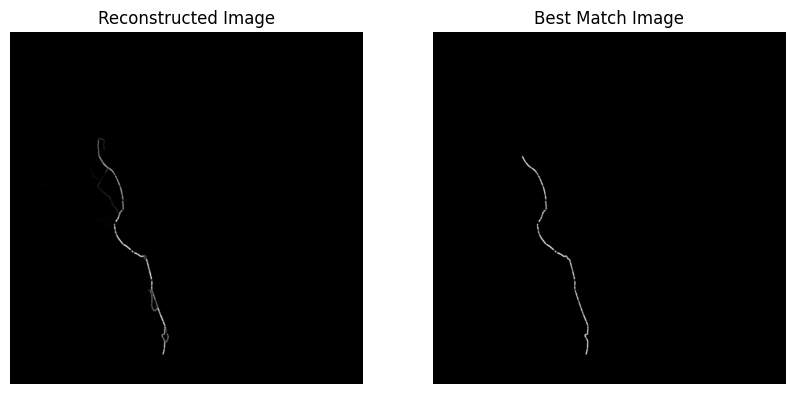

Best match image saved at best_match_images\best_match_image_4585.png
Best match percentage of white pixels preserved: 90.53%


In [20]:
# Example usage
images = []
images = find_best_matching_image(model, route_dataset, image_index=5)

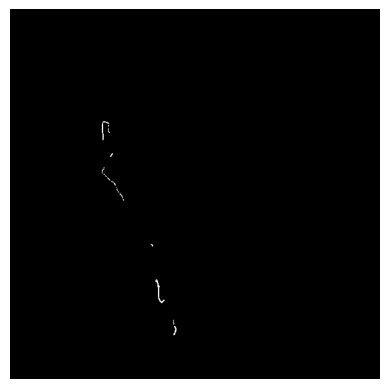

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


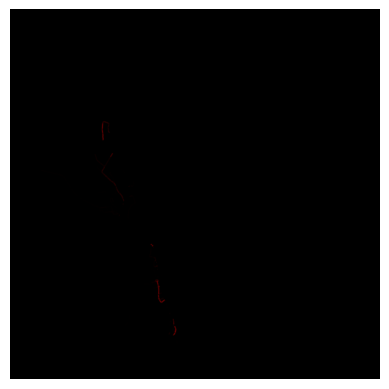

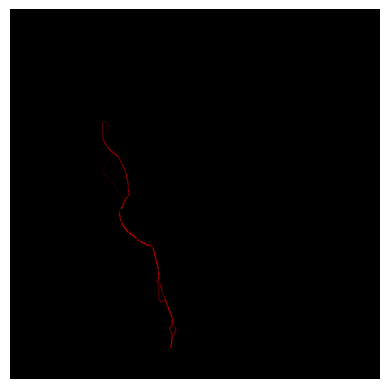

In [21]:
best_match_rgb = images[0]
best_match = images[1]
valid_extra = multiplied_result - best_match_rgb

import matplotlib.pyplot as plt
import numpy as np

# Assuming `image` is your input image loaded as a NumPy array
# Convert the image to grayscale if it's not already
if valid_extra.ndim == 3:
    # Convert to grayscale by averaging the color channels
    gray_image = np.mean(valid_extra, axis=2)
else:
    gray_image = valid_extra

# Set a threshold value (e.g., 0.1 for normalized values or 25 for 0-255 range)
threshold_value = 0.03  # Adjust as needed

# Create a binary image: anything above the threshold becomes white (1), otherwise black (0)
binary_image = np.where(gray_image > threshold_value, 1, 0)

# Plot the binary image
plt.imshow(binary_image, cmap='gray', vmin=0, vmax=1)
plt.axis('off')  # Hide axes for a cleaner look
plt.show()


# Plot the image
plt.imshow(valid_extra, cmap='gray')
plt.axis('off')  # Hide axes for a cleaner look
plt.show()

# Plot the image
plt.imshow(multiplied_result, cmap='gray')
plt.axis('off')  # Hide axes for a cleaner look
plt.show()


In [22]:
from PIL import Image
import numpy as np

def calculate_overlap_percentage(image1, image2):

    # Convert images to numpy arrays
    img1_array = np.array(image1)
    img2_array = np.array(image2)

    # Ensure the images are of the same size
    assert img1_array.shape == img2_array.shape, "Images are not the same size"

    # Calculate number of matching pixels
    matching_pixels = np.sum(img1_array == img2_array)

    # Total number of pixels
    total_pixels = img1_array.size

    # Calculate the percentage of overlap
    overlap_percentage = (matching_pixels / total_pixels) * 100
    return overlap_percentage

overlap_percentage = calculate_overlap_percentage(valid_extra, multiplied_result)
print(f"Valid extra / valid generated | Overlap Percentage: {overlap_percentage:.2f}%")

Valid extra / valid generated | Overlap Percentage: 99.55%


# Novelty és novelty + valid
  - best match - reconstruction -> extra_generátum
  - extra_generatum / best pixelek count -> Novelty
  
  - generált * térkép -> valid
  - best match - valid -> valid extra
  - valid extra / valid generált -> Validity $\cap$ Novelty

In [33]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def generate_random_images_in_latent_space(model, dataset, image_index, epsilon=0.1, num_variations=5):
    
    model.eval()

    # Retrieve and preprocess the image
    original_img, _ = dataset[image_index]
    original_img = original_img.view(1, -1).to(device)
    
     # Reconstruct the image using the VAE
    with torch.no_grad():
        reconstructed_img, mean, log_var = model(original_img)
    
    # Get the original latent vector by reparameterizing
    original_z = model.reparameterization(mean, torch.exp(0.5 * log_var))

    fig, axs = plt.subplots(1, num_variations + 1, figsize=(15, 5))
    axs[0].imshow(reconstructed_img.cpu().view(image_size, image_size).detach(), cmap='gray')
    axs[0].set_title("Original Reconstructed Image")
    axs[0].axis("off")
    
    perturbed_images = []

    for i in range(1, num_variations + 1):
        # Perturb the latent vector with a small random noise within epsilon range
        perturbed_z = original_z + epsilon * torch.randn_like(original_z).to(device)

        # Decode the perturbed latent vector to get the new image
        perturbed_image = model.decode(perturbed_z).view(image_size, image_size).cpu().detach()
        perturbed_images.append(perturbed_image)

         #Plot the perturbed image
        axs[i].imshow(perturbed_image, cmap='gray')
        axs[i].set_title(f"Perturbation {i}")
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()
    
    return perturbed_images

# Call the function to see variations
#generate_random_images_in_latent_space(model, route_dataset, image_index=20, epsilon=0.7, num_variations=3)

In [34]:
import numpy as np

def compare_images(img1_array, img2_array):
    
    img1_array = img1_array[:,:,0]
    img2_array = img2_array[:,:,0]
    img1_array = img1_array > 0.03
    img2_array = img2_array > 0.03
    
    print(f"img1_array, img2_array {np.sum(img1_array), np.sum(img2_array)}")
    
    plt.imshow(img1_array)
    plt.show()
    plt.imshow(img2_array)
    plt.show()
    # Ensure both images are of the same shape
    if img1_array.shape != img2_array.shape:
        raise ValueError("Images must have the same dimensions for comparison.")
    
    # Create a mask where at least one of the images is not black
    mask = (img1_array != 0) | (img2_array != 0)
    
    # Compare pixels where the mask is True
    comparison = (img1_array[mask] == img2_array[mask])
    
    # Calculate the percentage of similar pixels, ignoring black pixels
    if comparison.size > 0:  # Check to avoid division by zero
        similarity_percentage = np.sum(comparison) / comparison.size * 100
    else:
        similarity_percentage = 0.0  # No non-black pixels to compare
    
    return similarity_percentage


In [35]:
def find_most_similar_image(model, dataset, input_image): 

 # Reshape the input and reconstructed images
    input_image_np = input_image.view(image_size, image_size).cpu().numpy()

    best_percentage = 0
    best_image = None
    best_image_index = -1

    # Iterate over each image in the dataset
    for idx in range(len(dataset)):
        # Get the original image from the dataset
        comparison_img, _ = dataset[idx]
        comparison_img_np = comparison_img.view(image_size, image_size).cpu().numpy()

        # Calculate preserved white pixels
        input_white_pixels = np.sum(input_image_np > 0.03)  # Count white pixels in the reconstructed input
        preserved_white_pixels = np.sum((input_image_np > 0.03) & (comparison_img_np > 0.03))  # Count preserved white pixels

        # Calculate the percentage of preserved white pixels
        percentage_preserved = (preserved_white_pixels / input_white_pixels * 100) if input_white_pixels > 0 else 0

        # Check if this is the best match
        if percentage_preserved > best_percentage:
            best_percentage = percentage_preserved
            best_image = comparison_img_np

    # Plot and save the most similar image
    if best_image is not None:
        # Convert best image to RGB
        best_image_rgb = np.stack([best_image] * 3, axis=-1)
        reconstructed_img_np_rgb = np.stack([input_image_np] * 3, axis=-1)
        
        best_images = [best_image_rgb, best_image, reconstructed_img_np_rgb]

        # Plot the reconstructed input image and the best similar image
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Reconstructed Input Image
        axes[0].imshow(input_image_np, cmap='gray')
        axes[0].axis('off')
        axes[0].set_title("Reconstructed Input Image")

        # Most Similar Image
        axes[1].imshow(best_image_rgb, cmap='gray')
        axes[1].axis('off')
        axes[1].set_title("Most Similar Image")

        plt.show()

        # Print the percentage of preserved white pixels
        print(f"Most similar image percentage of white pixels preserved: {best_percentage:.2f}%")
    else:
        print("No similar image found.")
        best_images = [reconstructed_img_np_rgb, reconstructed_img_np_rgb, reconstructed_img_np_rgb]
        
    return best_images


In [36]:
from PIL import Image
import os

def plot_multiplied_image(model, dataset, map_plot_tensor, input_image):

    # Reshape the reconstructed image to RGB
    input_image_np = input_image.view(image_size, image_size).cpu().numpy()
    input_image_rgb = np.stack([input_image_np] * 3, axis=-1)  # Duplicate channels for RGB

    # Convert the map_plot to a numpy array
    map_plot_np = map_plot_tensor.permute(1, 2, 0).cpu().numpy()

    # Multiply each channel independently
    multiplied_result = input_image_rgb * map_plot_np

    # Plot the reconstructed and multiplied images side-by-side in color
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Reconstructed Image in Color
    axes[0].imshow(input_image_rgb)
    axes[0].axis('off')
    axes[0].set_title("Reconstructed Image")

    # Multiplied Image in Color
    axes[1].imshow(multiplied_result)
    axes[1].axis('off')
    axes[1].set_title("Multiplied Image (Valid)")

    plt.show()
    
    return multiplied_result

Optimal Threshold: 0.0073
Max Youden's J statistic: 0.9909
TPR: 0.9980, FPR: 0.0071


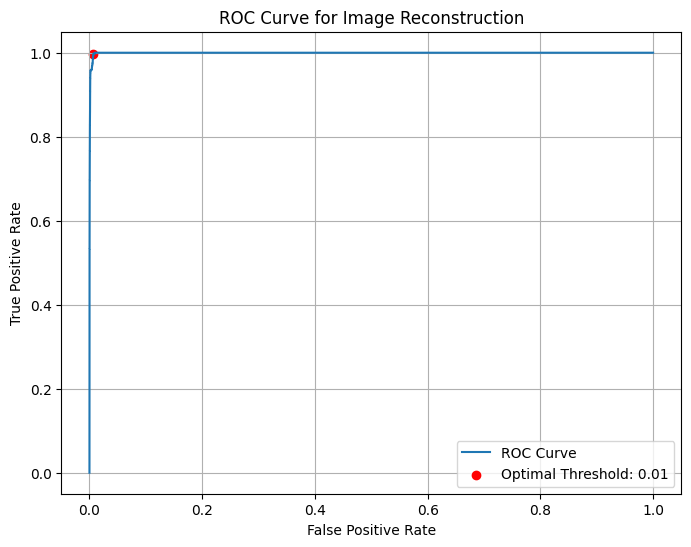

Determined optimal threshold: 0.007298693060874939


In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, classification_report

def calculate_optimal_threshold(model, dataset, image_index, plot_roc=True):

    model.eval()

    # Retrieve and preprocess the image
    original_img, _ = dataset[image_index]
    original_img = original_img.view(1, -1).to(device)

    # Reconstruct the image using the VAE
    with torch.no_grad():
        reconstructed_img, _, _ = model(original_img)

    # Reshape the original and reconstructed images to (image_size, image_size)
    original_img_np = original_img.view(image_size, image_size).cpu().numpy()
    reconstructed_img_np = reconstructed_img.view(image_size, image_size).cpu().numpy()

    # Flatten the images
    original_flat = original_img_np.flatten()
    reconstructed_flat = reconstructed_img_np.flatten()

    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(original_flat > 0.5, reconstructed_flat)

    # Calculate Youden's J statistic (TPR - FPR)
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    optimal_threshold = thresholds[optimal_idx]

    # Print the optimal threshold
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Max Youden's J statistic: {youden_j[optimal_idx]:.4f}")
    print(f"TPR: {tpr[optimal_idx]:.4f}, FPR: {fpr[optimal_idx]:.4f}")

    # Plot the ROC curve with the optimal threshold
    if plot_roc:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label='ROC Curve')
        plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold: {optimal_threshold:.2f}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Image Reconstruction')
        plt.legend()
        plt.grid()
        plt.show()

    return optimal_threshold

# Example usage
image_index = 5  # You can change this index to analyze a different image
optimal_threshold = calculate_optimal_threshold(model, route_dataset, image_index)
print(f"Determined optimal threshold: {optimal_threshold}")


Image 1: Optimal Threshold: 0.0121
Max Youden's J: 0.9877
TPR: 1.0000, FPR: 0.0123
Image 2: Optimal Threshold: 0.0114
Max Youden's J: 0.9867
TPR: 1.0000, FPR: 0.0133
Image 3: Optimal Threshold: 0.0339
Max Youden's J: 0.9935
TPR: 1.0000, FPR: 0.0065
Image 4: Optimal Threshold: 0.0066
Max Youden's J: 0.9932
TPR: 1.0000, FPR: 0.0068
Image 5: Optimal Threshold: 0.0101
Max Youden's J: 0.9906
TPR: 0.9979, FPR: 0.0073
Image 6: Optimal Threshold: 0.0041
Max Youden's J: 0.9906
TPR: 1.0000, FPR: 0.0094
Image 7: Optimal Threshold: 0.0018
Max Youden's J: 0.9760
TPR: 0.9983, FPR: 0.0223
Image 8: Optimal Threshold: 0.0348
Max Youden's J: 0.9949
TPR: 1.0000, FPR: 0.0051
Image 9: Optimal Threshold: 0.0359
Max Youden's J: 0.9944
TPR: 1.0000, FPR: 0.0056
Image 10: Optimal Threshold: 0.0314
Max Youden's J: 0.9942
TPR: 1.0000, FPR: 0.0058

Overall Optimal Threshold: 0.0182
Average Youden's J statistic: 0.9902


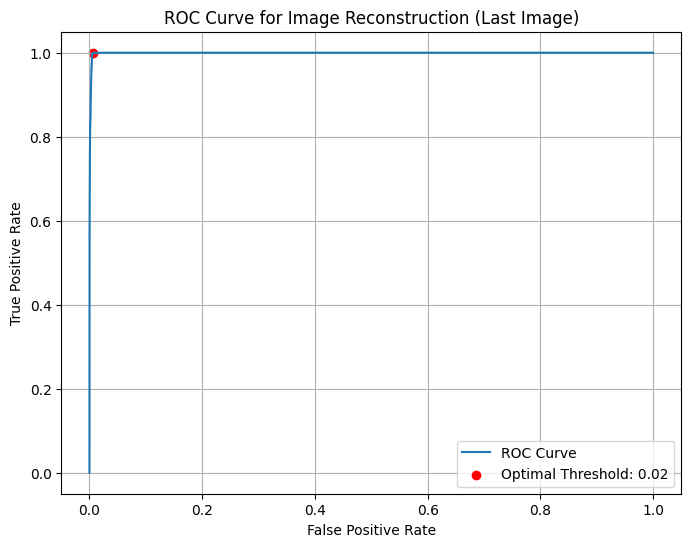

Overall optimal threshold: 0.01820828765630722


In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, classification_report

def calculate_optimal_threshold_for_dataset(model, dataset, num_cases=10, plot_roc=True):
    model.eval()

    # Initialize variables to store aggregated results
    thresholds_list = []
    youden_j_list = []

    # Loop over the specified number of cases in the dataset
    for image_index in range(num_cases):
        # Retrieve and preprocess the image
        original_img, _ = dataset[image_index]
        original_img = original_img.view(1, -1).to(device)

        # Reconstruct the image using the VAE
        with torch.no_grad():
            reconstructed_img, _, _ = model(original_img)

        # Reshape the original and reconstructed images to (image_size, image_size)
        original_img_np = original_img.view(image_size, image_size).cpu().numpy()
        reconstructed_img_np = reconstructed_img.view(image_size, image_size).cpu().numpy()

        # Flatten the images
        original_flat = original_img_np.flatten()
        reconstructed_flat = reconstructed_img_np.flatten()

        # Compute the ROC curve
        fpr, tpr, thresholds = roc_curve(original_flat > 0.5, reconstructed_flat)

        # Calculate Youden's J statistic (TPR - FPR)
        youden_j = tpr - fpr
        optimal_idx = np.argmax(youden_j)
        optimal_threshold = thresholds[optimal_idx]

        # Store the optimal threshold and Youden's J statistic
        thresholds_list.append(optimal_threshold)
        youden_j_list.append(youden_j[optimal_idx])

        # Optionally, print the optimal threshold for each case
        print(f"Image {image_index + 1}: Optimal Threshold: {optimal_threshold:.4f}")
        print(f"Max Youden's J: {youden_j[optimal_idx]:.4f}")
        print(f"TPR: {tpr[optimal_idx]:.4f}, FPR: {fpr[optimal_idx]:.4f}")

    # Calculate the average optimal threshold across all images
    avg_optimal_threshold = np.mean(thresholds_list)
    avg_youden_j = np.mean(youden_j_list)

    # Print the overall optimal threshold and Youden's J
    print(f"\nOverall Optimal Threshold: {avg_optimal_threshold:.4f}")
    print(f"Average Youden's J statistic: {avg_youden_j:.4f}")

    # Plot the ROC curve for the last image processed
    if plot_roc:
        fpr, tpr, thresholds = roc_curve(original_flat > 0.5, reconstructed_flat)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label='ROC Curve')
        plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold: {avg_optimal_threshold:.2f}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Image Reconstruction (Last Image)')
        plt.legend()
        plt.grid()
        plt.show()

    return avg_optimal_threshold, avg_youden_j

avg_optimal_threshold, avg_youden_j = calculate_optimal_threshold_for_dataset(model, route_dataset, num_cases=10)
print(f"Overall optimal threshold: {avg_optimal_threshold}")


# 1000Threshold = 0.026671214029192924
# 5000T = 0.03011510707437992

In [38]:
import random

# Generate 10 random numbers between 0 and 4999, allowing duplicates
random_numbers = random.choices(range(5000), k=10)
print(random_numbers)

[2794, 4034, 4228, 2200, 4602, 1777, 4846, 4939, 2691, 3269]


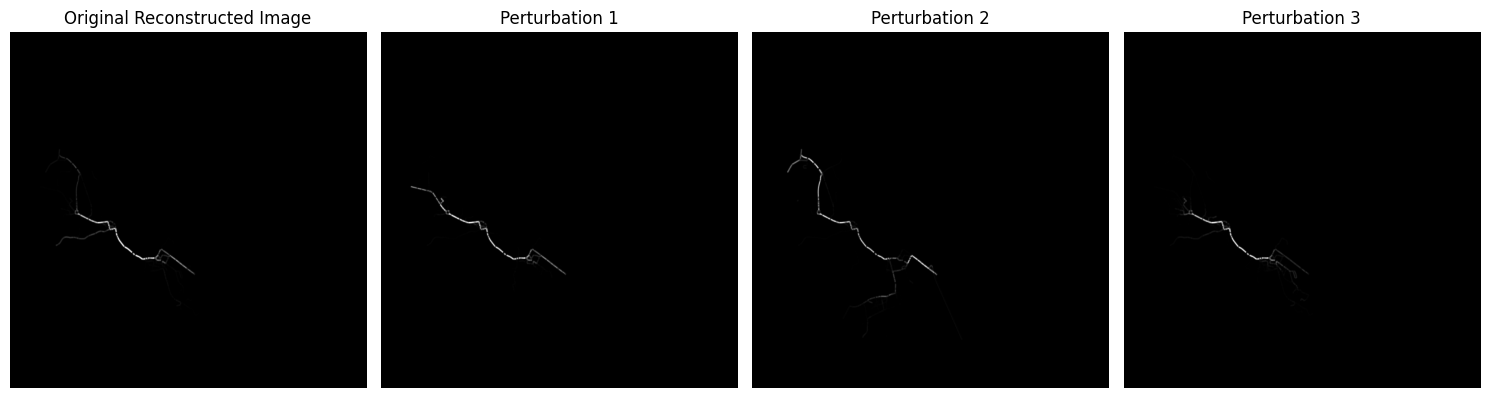

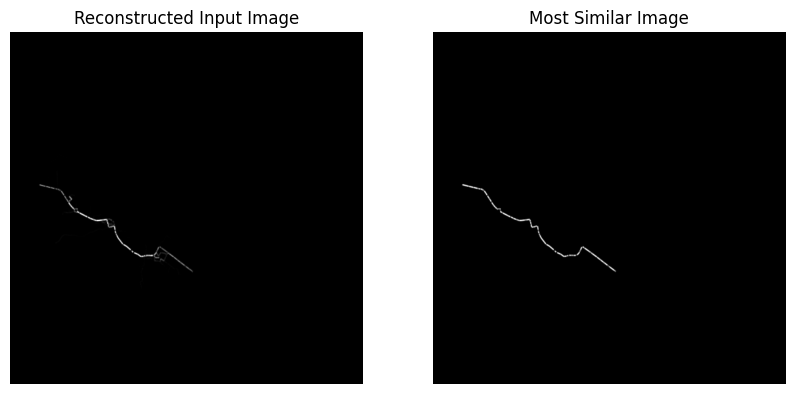

Most similar image percentage of white pixels preserved: 72.91%


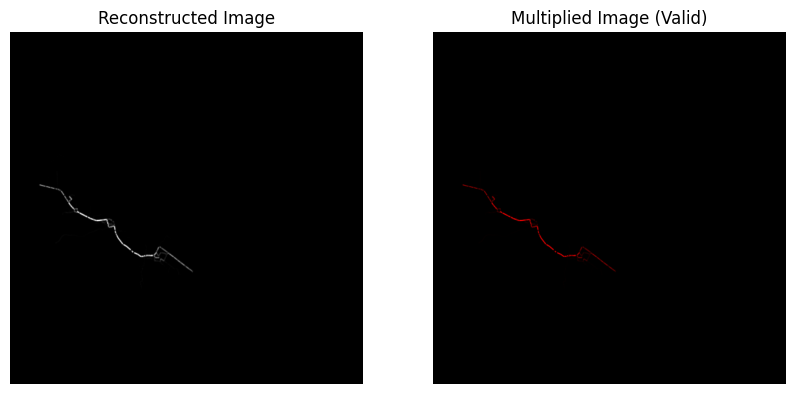

Compare reconstructed & invalid_extra
img1_array, img2_array (1617, 588)


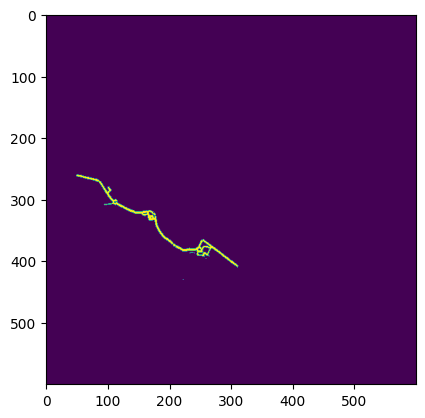

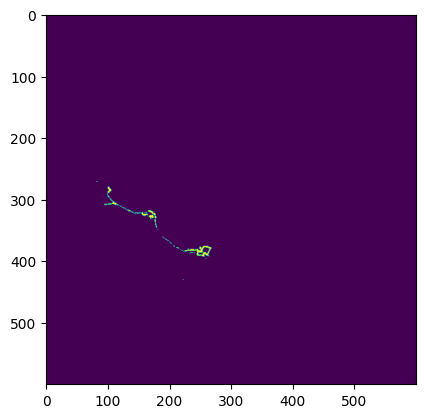

Index: 2794 perturbation 0
Percentage of similar pixels (ignoring black pixels): 36.36%
Novelty,tehát generátum az reconstructidhoz képest: 63.64%
Compare valid & valid_extra
img1_array, img2_array (1386, 419)


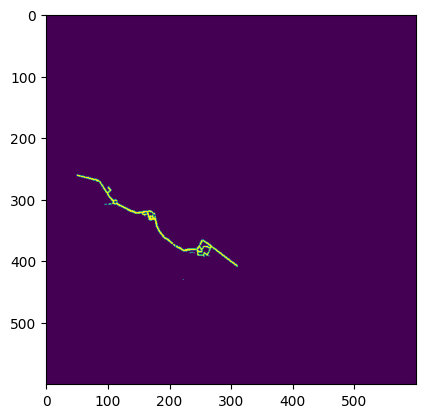

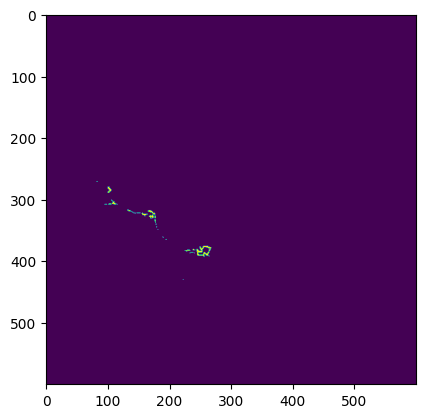

Percentage of similar pixels (ignoring black pixels): 30.23%
Validity + Novelty, tehát generált és helyes: 69.77%


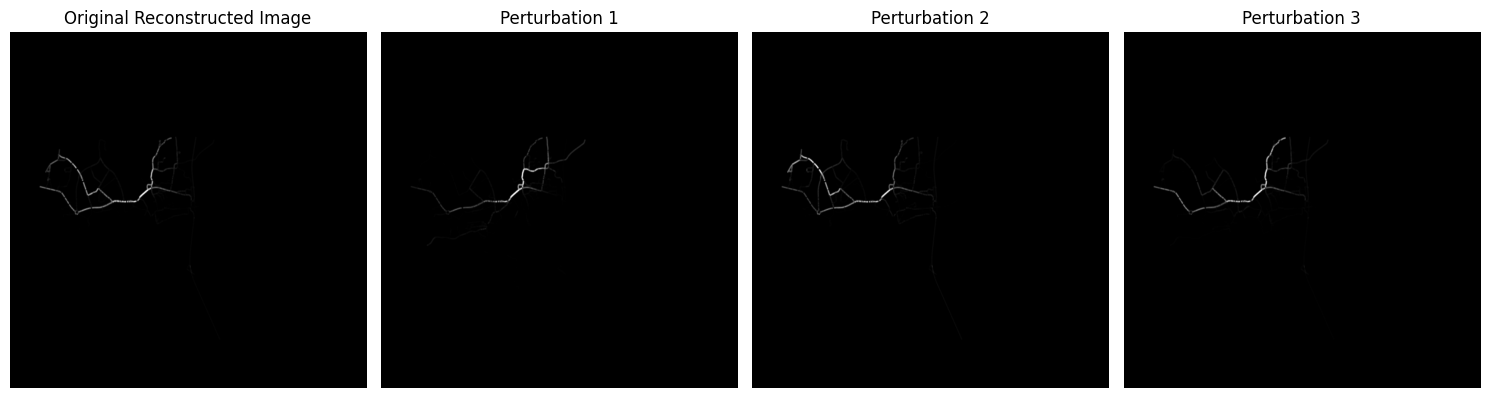

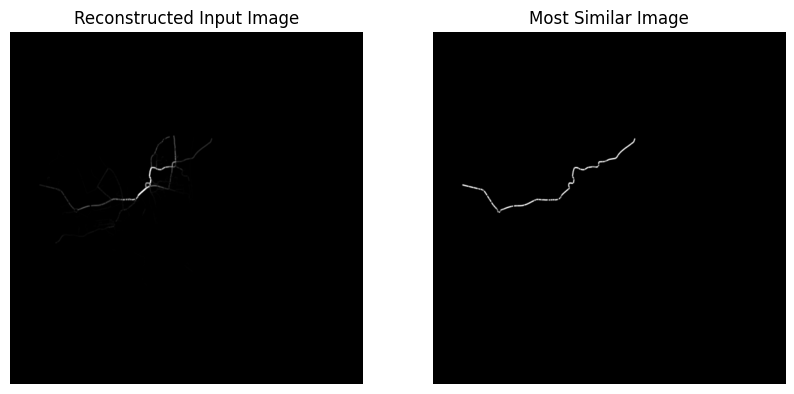

Most similar image percentage of white pixels preserved: 44.87%


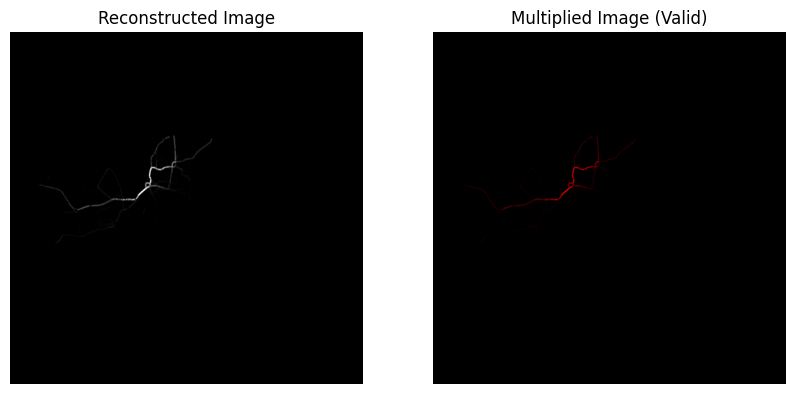

Compare reconstructed & invalid_extra
img1_array, img2_array (2766, 1716)


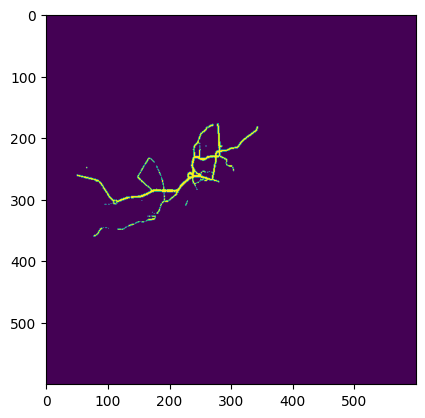

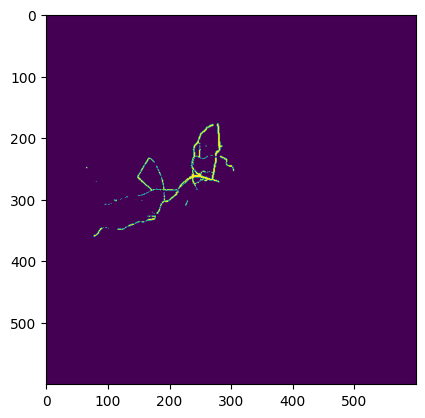

Index: 4034 perturbation 0
Percentage of similar pixels (ignoring black pixels): 62.04%
Novelty,tehát generátum az reconstructidhoz képest: 37.96%
Compare valid & valid_extra
img1_array, img2_array (2322, 1345)


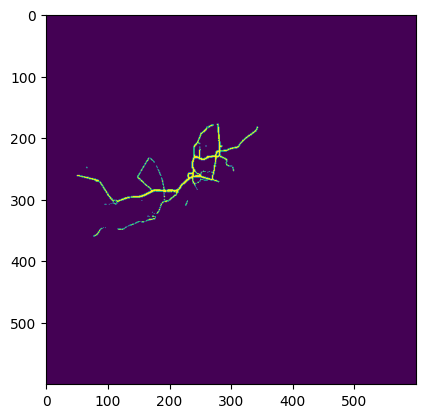

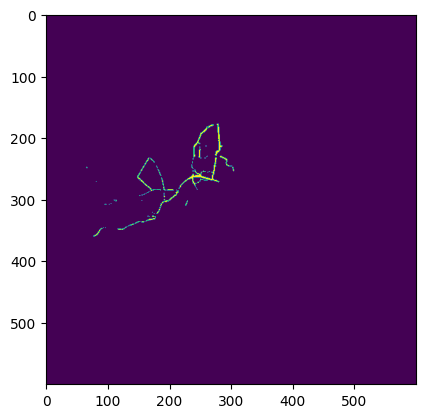

Percentage of similar pixels (ignoring black pixels): 57.92%
Validity + Novelty, tehát generált és helyes: 42.08%


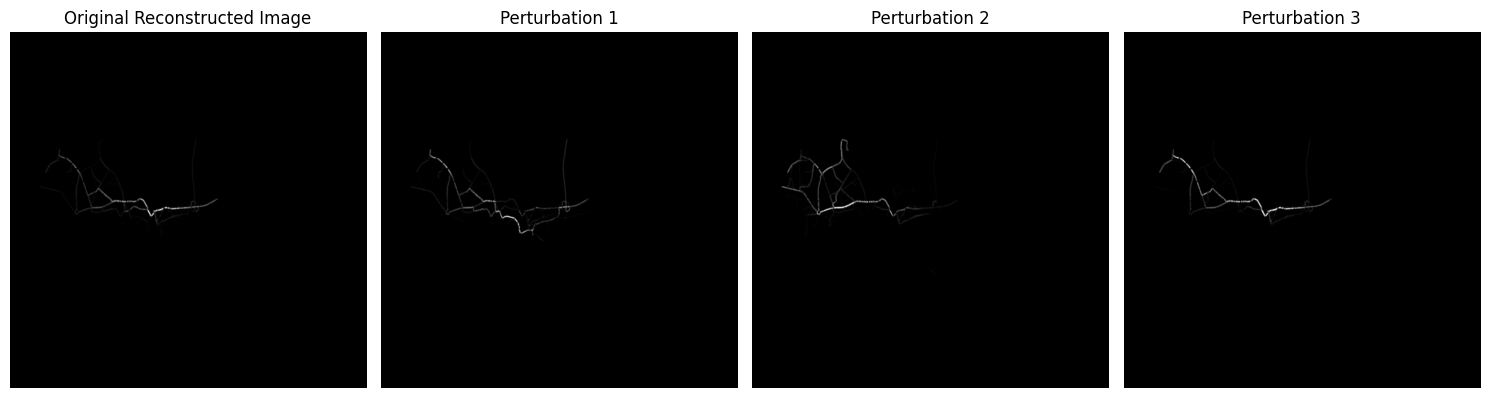

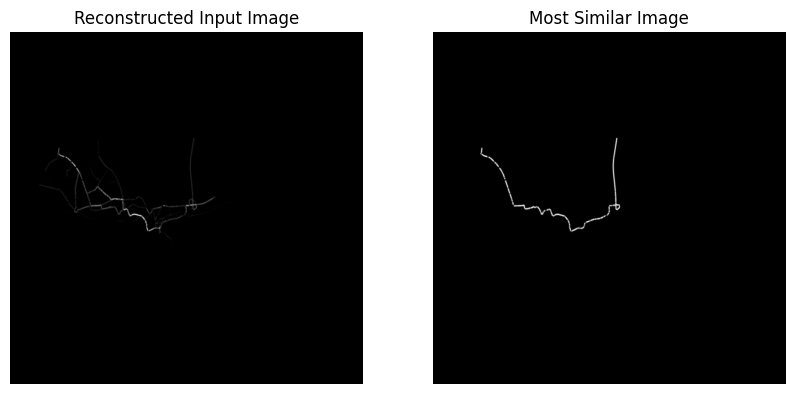

Most similar image percentage of white pixels preserved: 42.46%


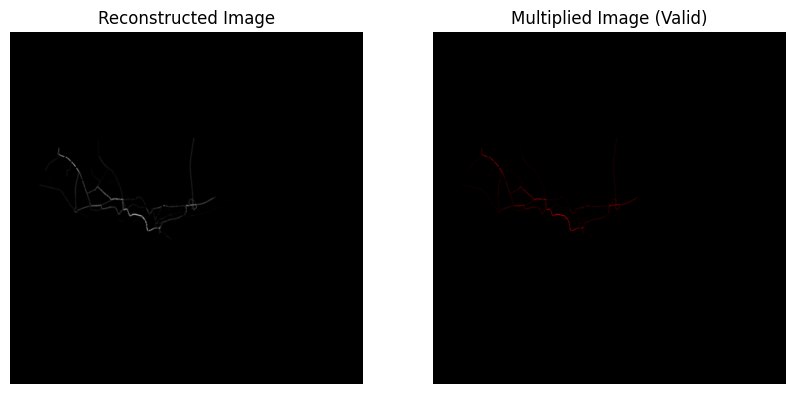

Compare reconstructed & invalid_extra
img1_array, img2_array (3394, 1959)


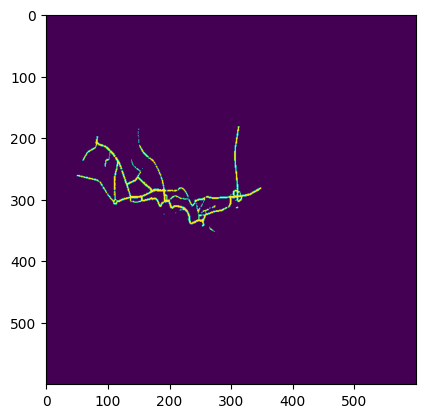

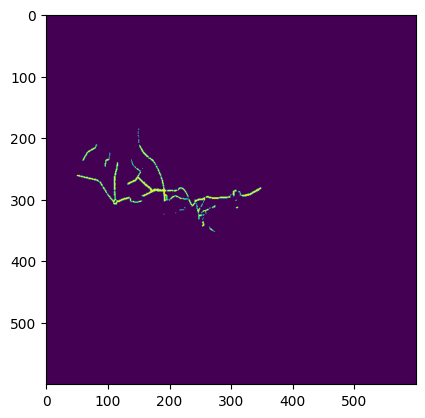

Index: 4228 perturbation 0
Percentage of similar pixels (ignoring black pixels): 57.72%
Novelty,tehát generátum az reconstructidhoz képest: 42.28%
Compare valid & valid_extra
img1_array, img2_array (2805, 1595)


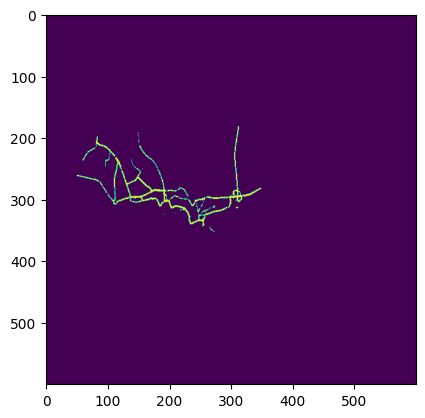

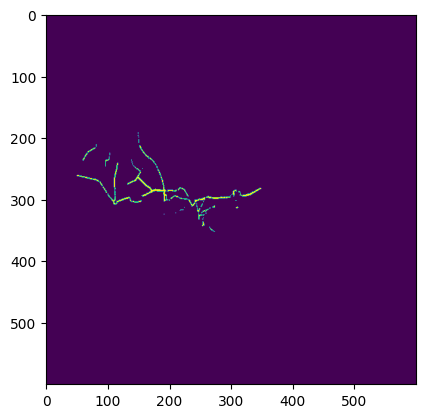

Percentage of similar pixels (ignoring black pixels): 56.86%
Validity + Novelty, tehát generált és helyes: 43.14%


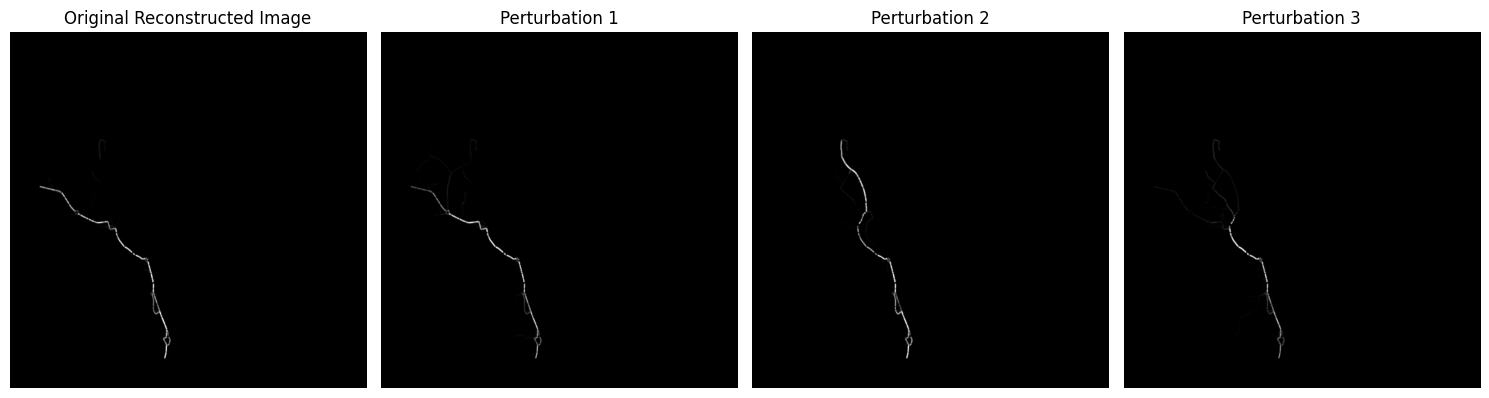

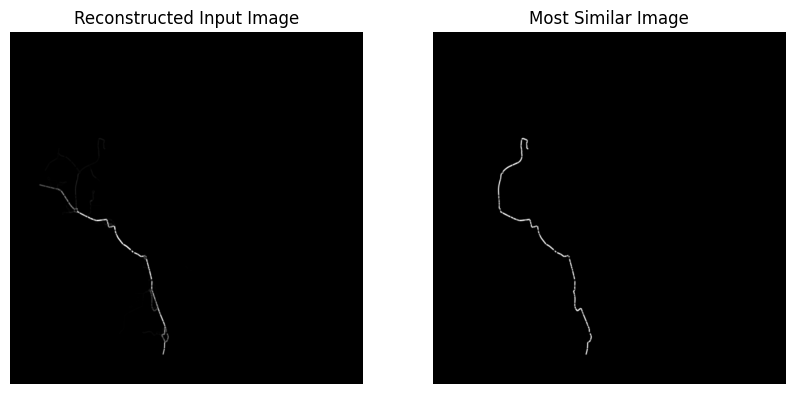

Most similar image percentage of white pixels preserved: 62.45%


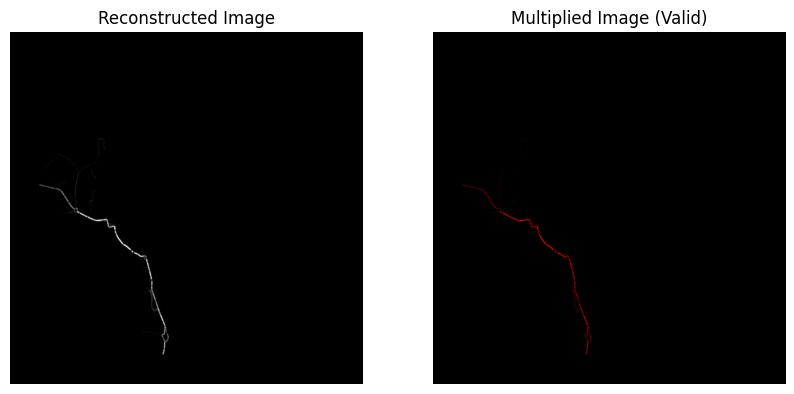

Compare reconstructed & invalid_extra
img1_array, img2_array (2370, 1071)


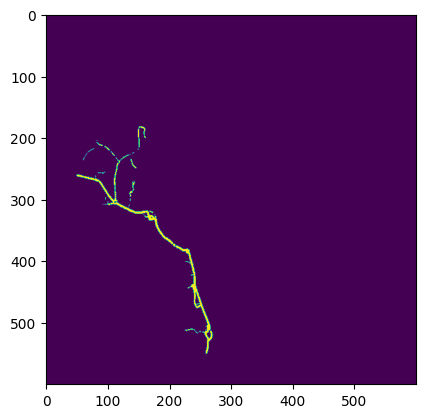

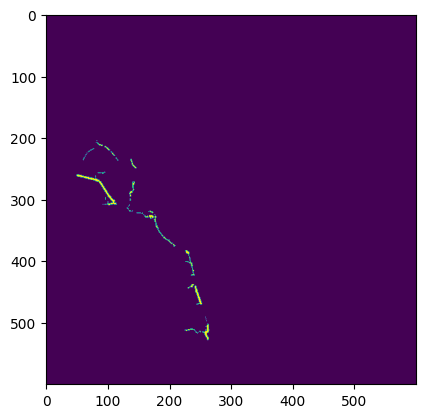

Index: 2200 perturbation 0
Percentage of similar pixels (ignoring black pixels): 45.19%
Novelty,tehát generátum az reconstructidhoz képest: 54.81%
Compare valid & valid_extra
img1_array, img2_array (1995, 833)


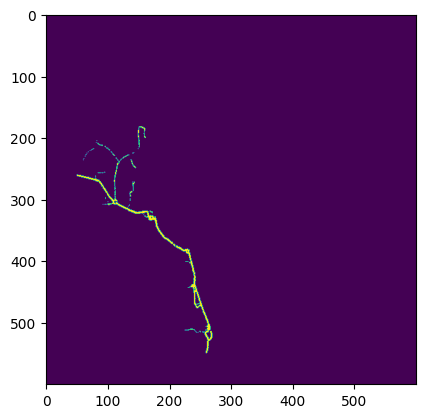

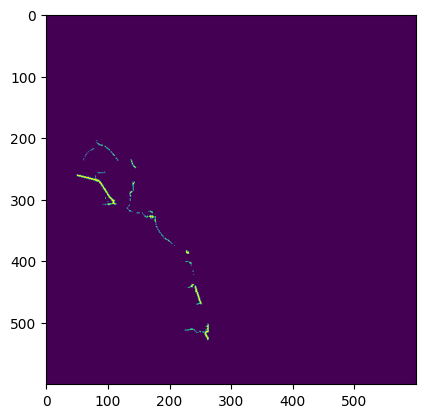

Percentage of similar pixels (ignoring black pixels): 41.75%
Validity + Novelty, tehát generált és helyes: 58.25%


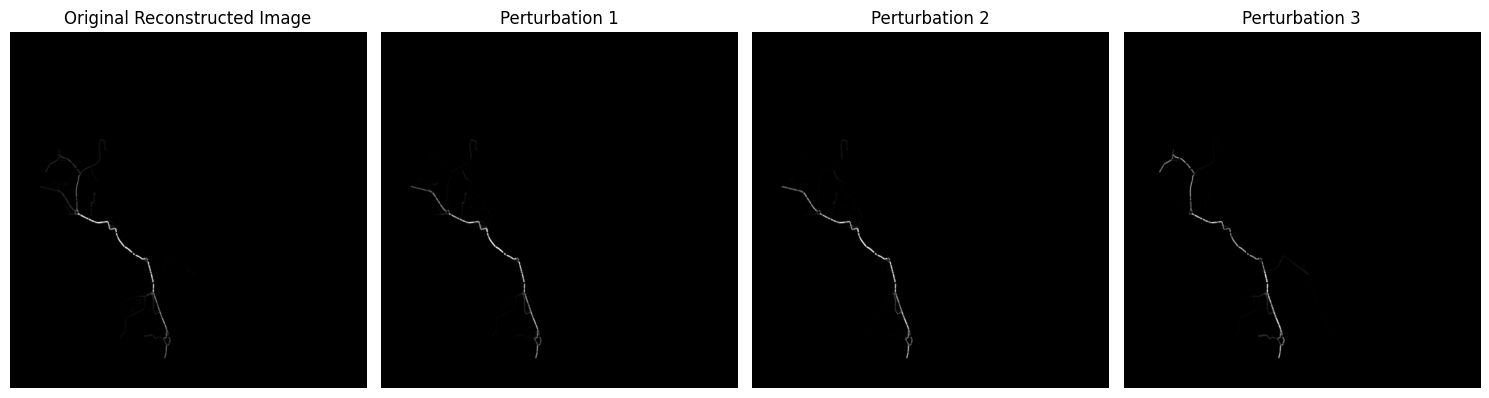

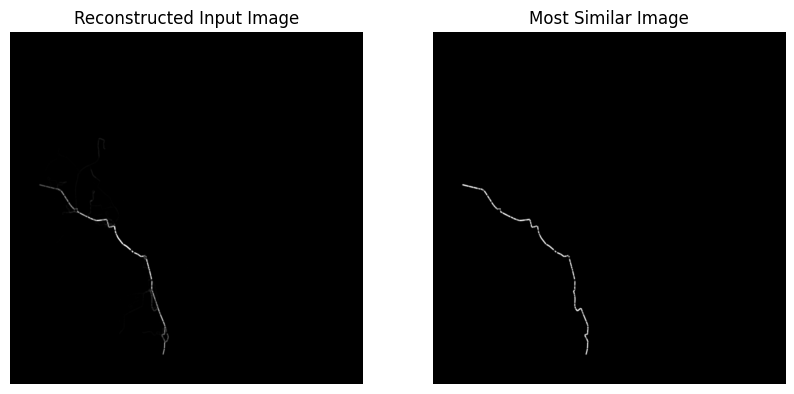

Most similar image percentage of white pixels preserved: 65.50%


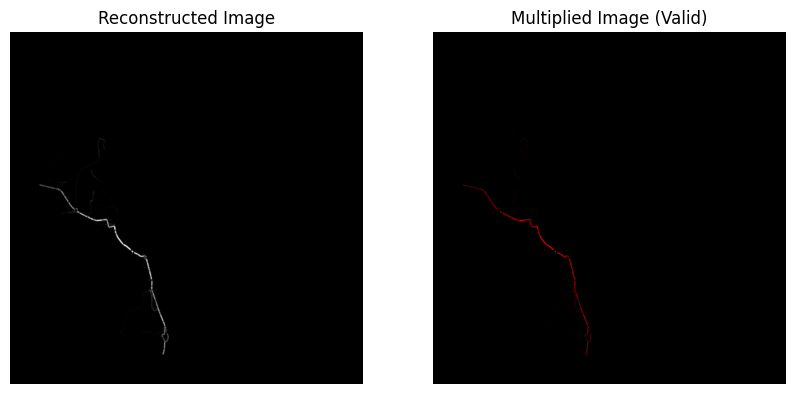

Compare reconstructed & invalid_extra
img1_array, img2_array (2235, 947)


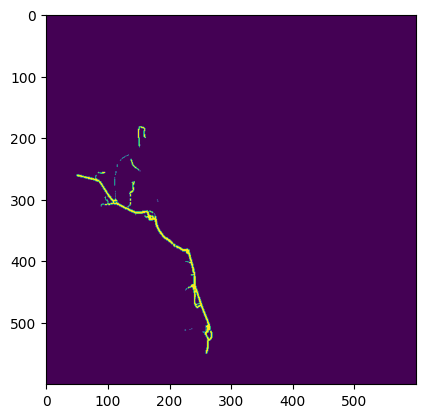

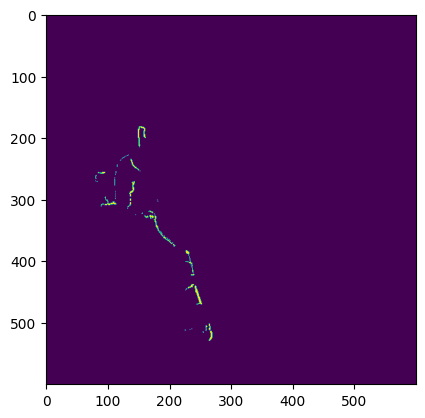

Index: 4602 perturbation 0
Percentage of similar pixels (ignoring black pixels): 42.37%
Novelty,tehát generátum az reconstructidhoz képest: 57.63%
Compare valid & valid_extra
img1_array, img2_array (1888, 704)


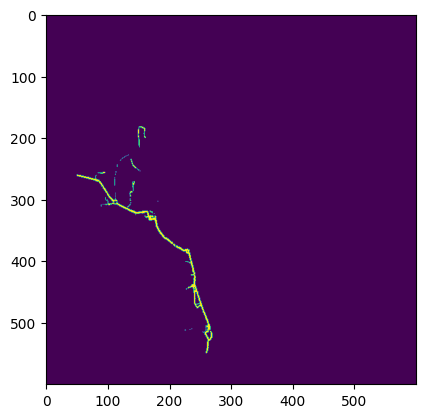

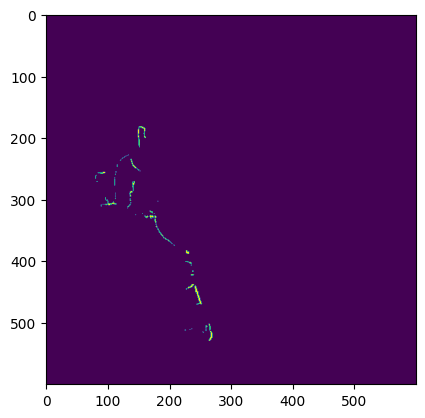

Percentage of similar pixels (ignoring black pixels): 37.29%
Validity + Novelty, tehát generált és helyes: 62.71%


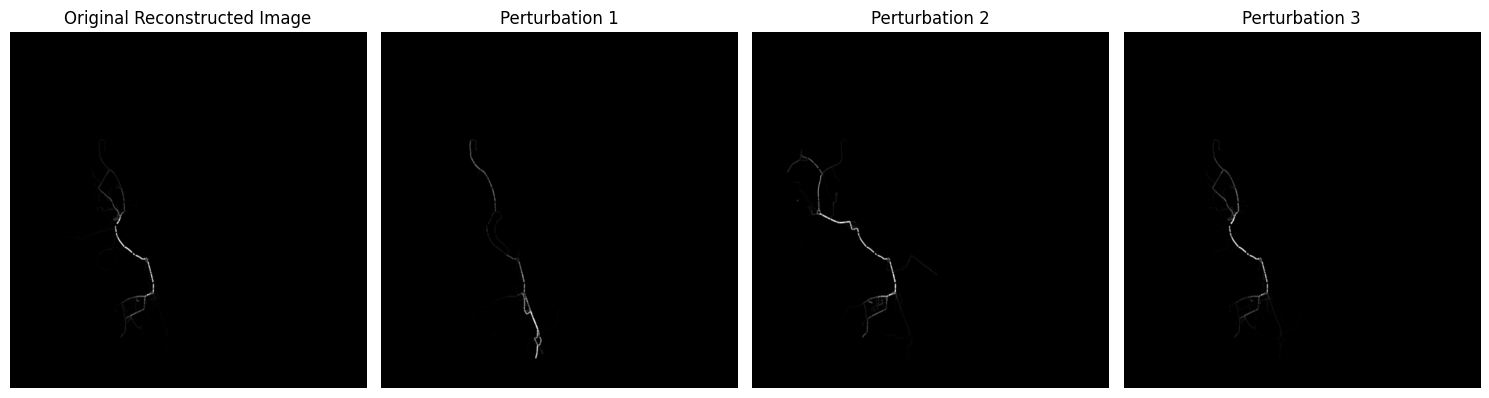

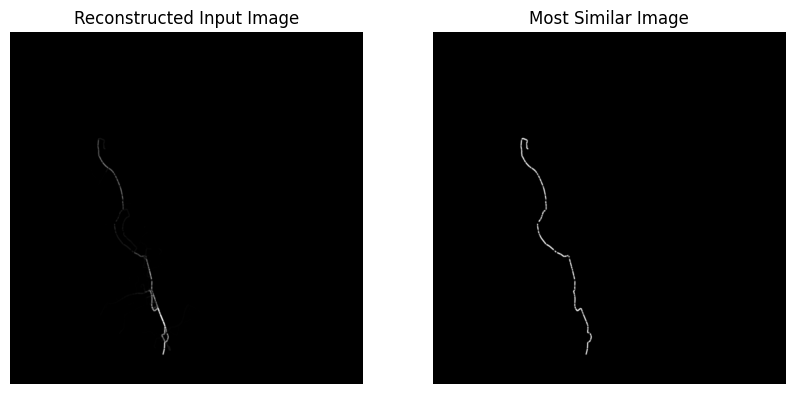

Most similar image percentage of white pixels preserved: 70.99%


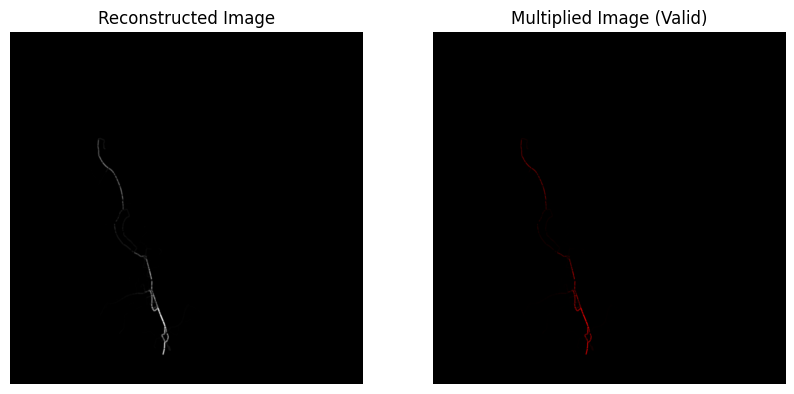

Compare reconstructed & invalid_extra
img1_array, img2_array (1913, 683)


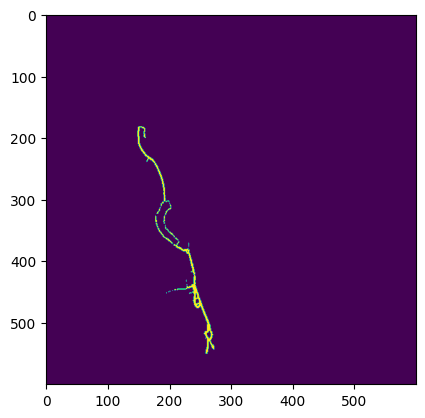

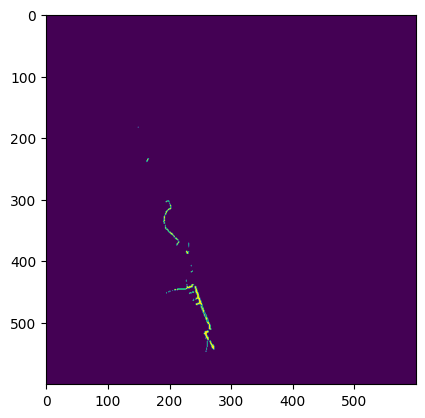

Index: 1777 perturbation 0
Percentage of similar pixels (ignoring black pixels): 35.70%
Novelty,tehát generátum az reconstructidhoz képest: 64.30%
Compare valid & valid_extra
img1_array, img2_array (1586, 501)


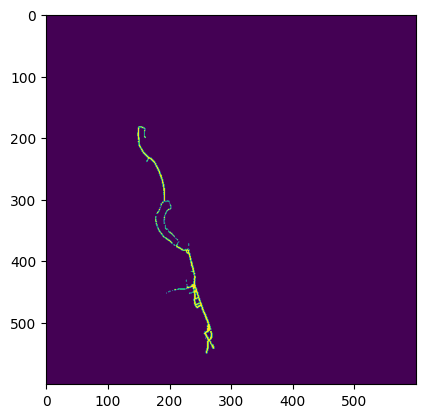

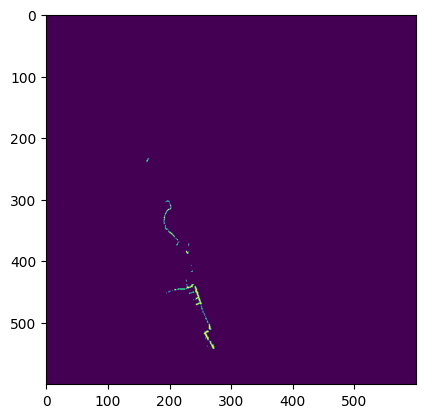

Percentage of similar pixels (ignoring black pixels): 31.59%
Validity + Novelty, tehát generált és helyes: 68.41%


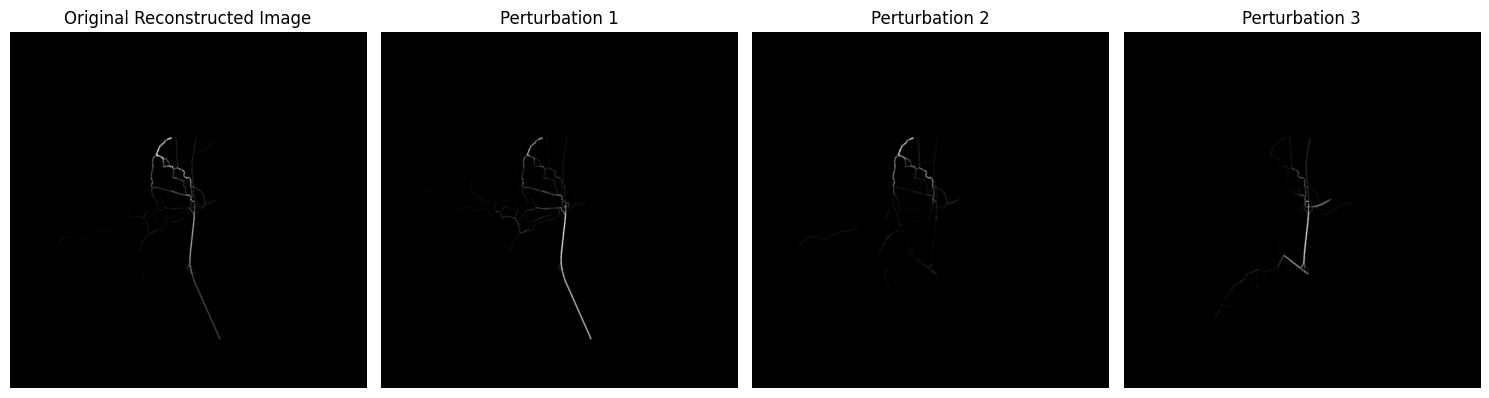

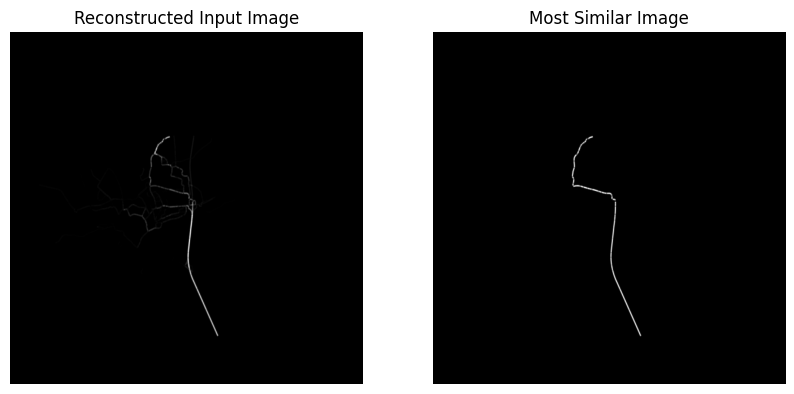

Most similar image percentage of white pixels preserved: 38.88%


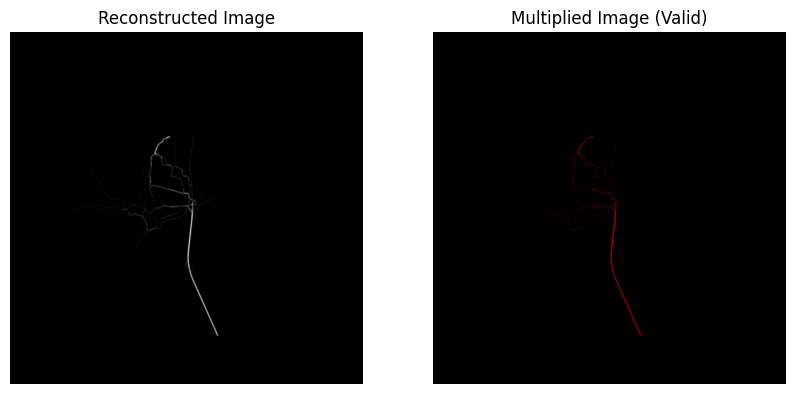

Compare reconstructed & invalid_extra
img1_array, img2_array (3609, 2423)


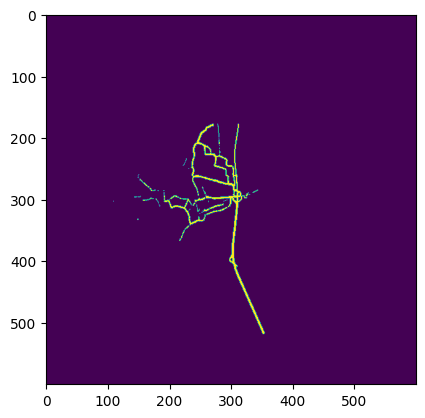

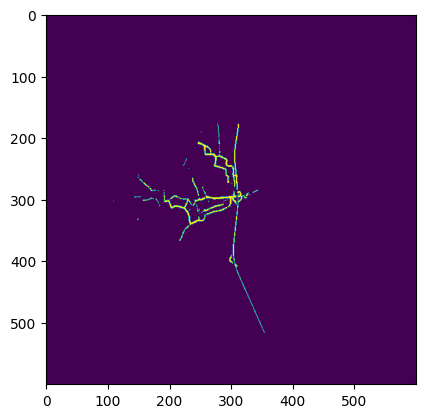

Index: 4846 perturbation 0
Percentage of similar pixels (ignoring black pixels): 67.14%
Novelty,tehát generátum az reconstructidhoz képest: 32.86%
Compare valid & valid_extra
img1_array, img2_array (3038, 1906)


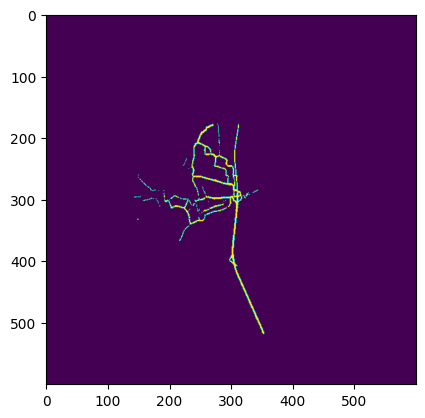

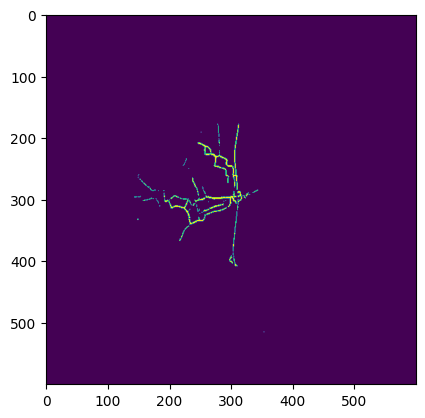

Percentage of similar pixels (ignoring black pixels): 62.74%
Validity + Novelty, tehát generált és helyes: 37.26%


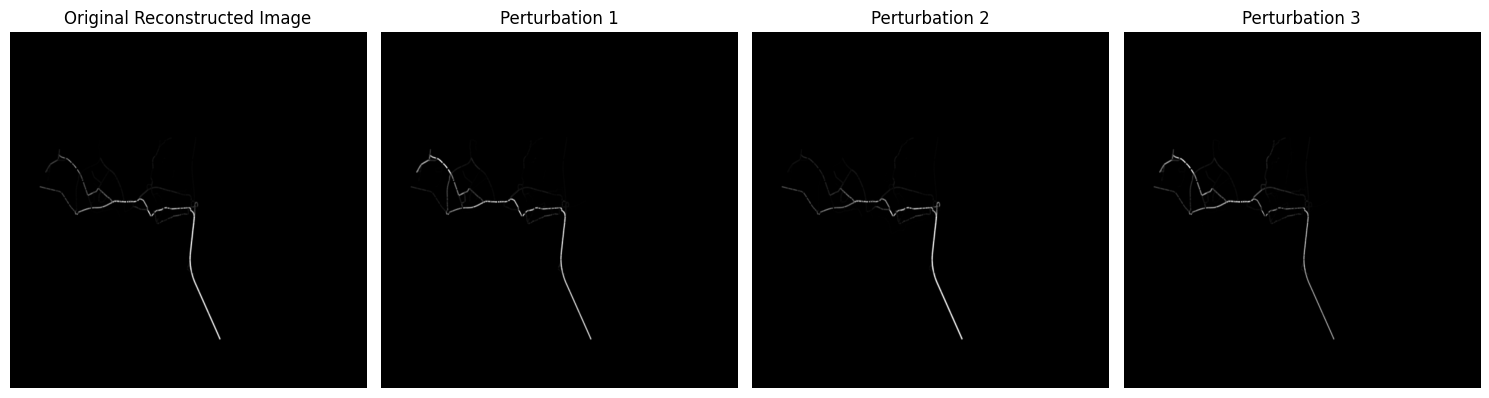

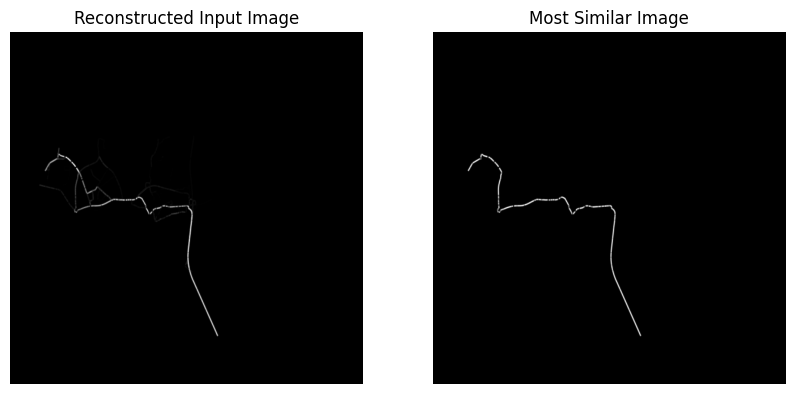

Most similar image percentage of white pixels preserved: 55.15%


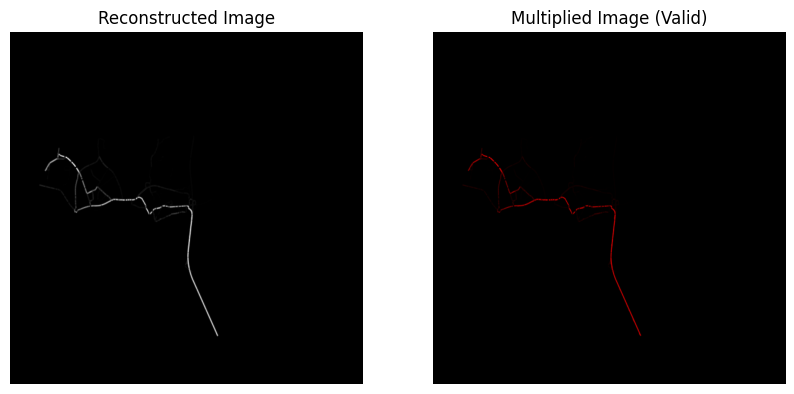

Compare reconstructed & invalid_extra
img1_array, img2_array (3826, 1791)


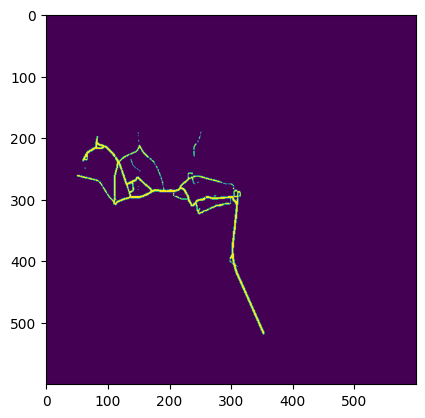

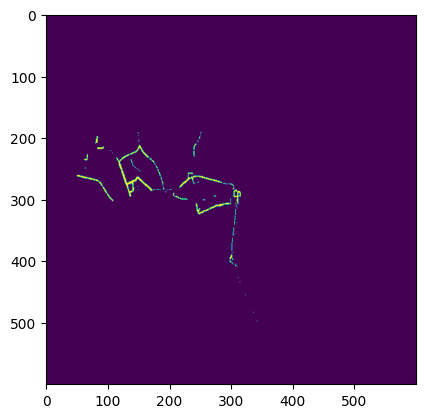

Index: 4939 perturbation 0
Percentage of similar pixels (ignoring black pixels): 46.81%
Novelty,tehát generátum az reconstructidhoz képest: 53.19%
Compare valid & valid_extra
img1_array, img2_array (3229, 1390)


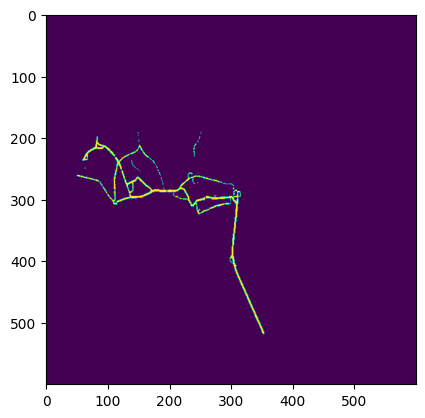

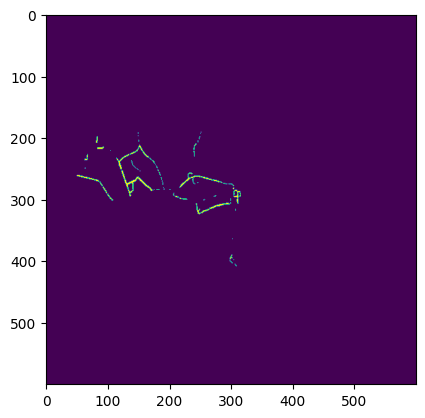

Percentage of similar pixels (ignoring black pixels): 43.05%
Validity + Novelty, tehát generált és helyes: 56.95%


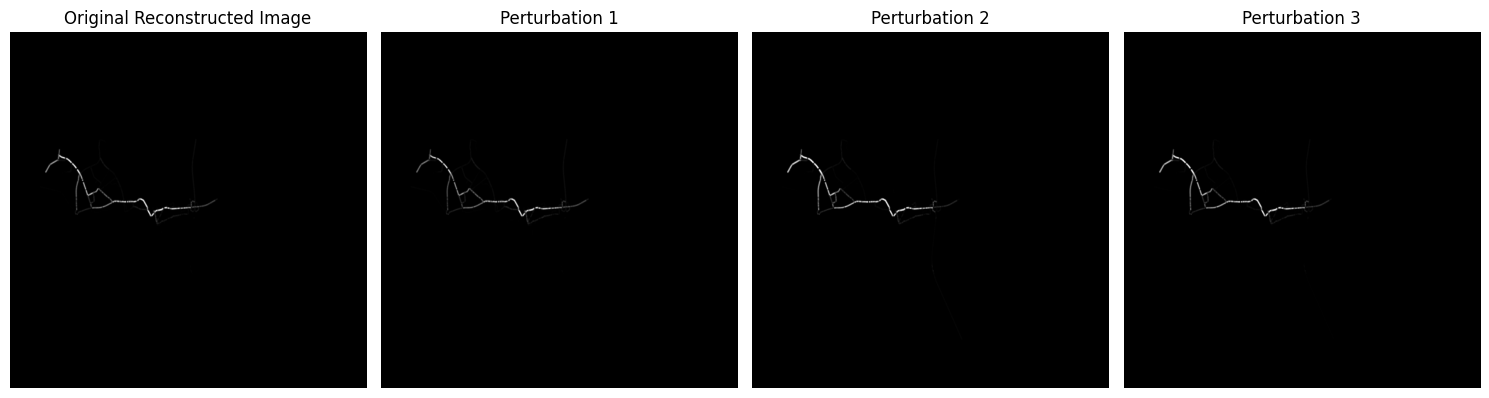

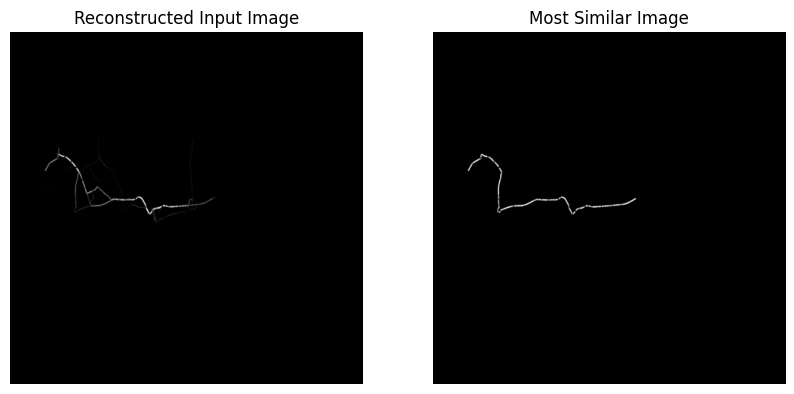

Most similar image percentage of white pixels preserved: 50.34%


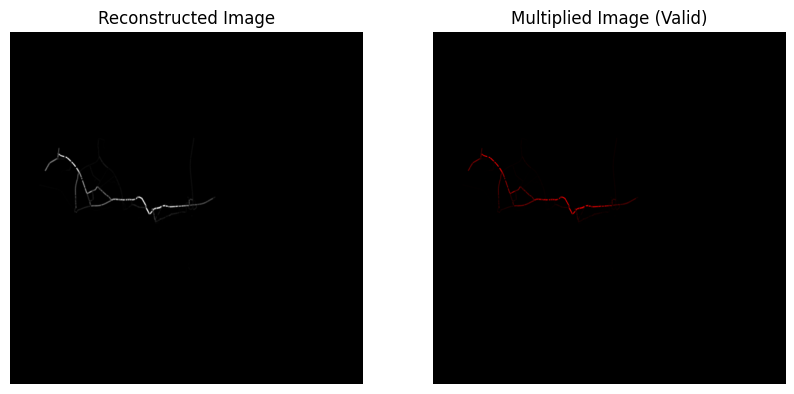

Compare reconstructed & invalid_extra
img1_array, img2_array (2785, 1555)


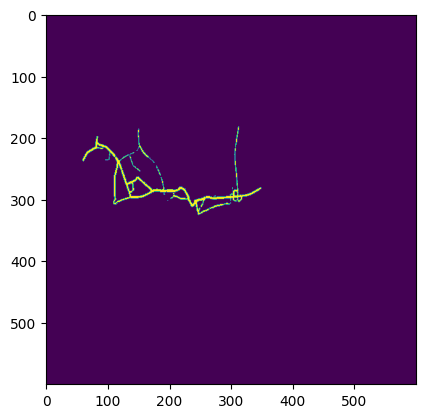

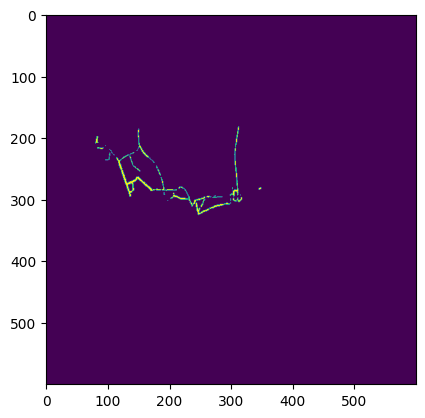

Index: 2691 perturbation 0
Percentage of similar pixels (ignoring black pixels): 55.83%
Novelty,tehát generátum az reconstructidhoz képest: 44.17%
Compare valid & valid_extra
img1_array, img2_array (2327, 1186)


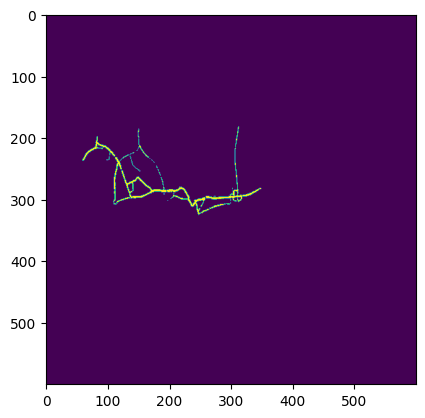

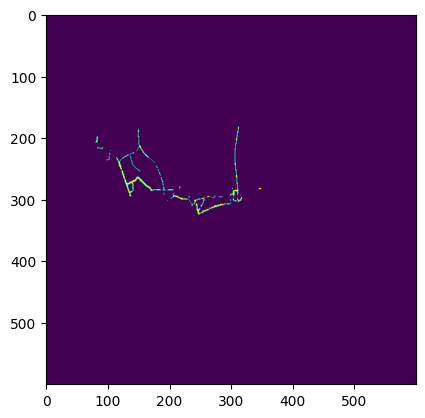

Percentage of similar pixels (ignoring black pixels): 50.97%
Validity + Novelty, tehát generált és helyes: 49.03%


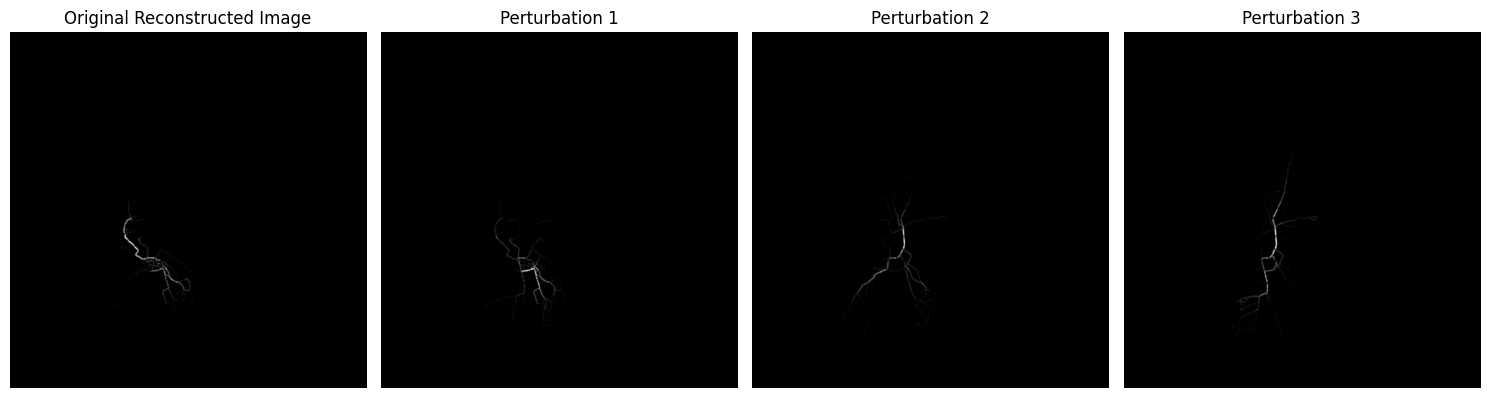

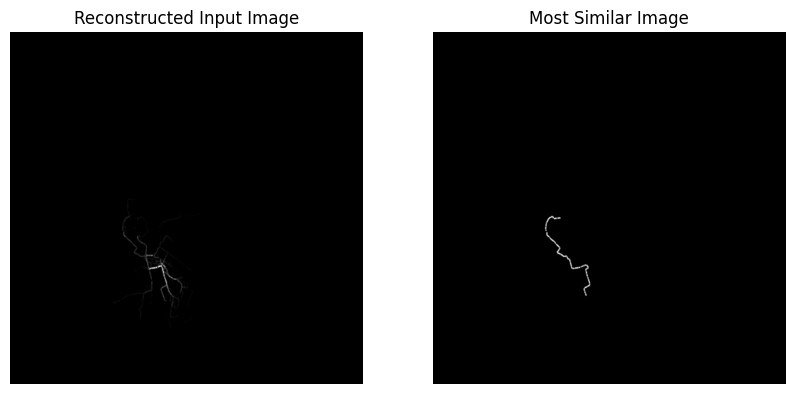

Most similar image percentage of white pixels preserved: 34.21%


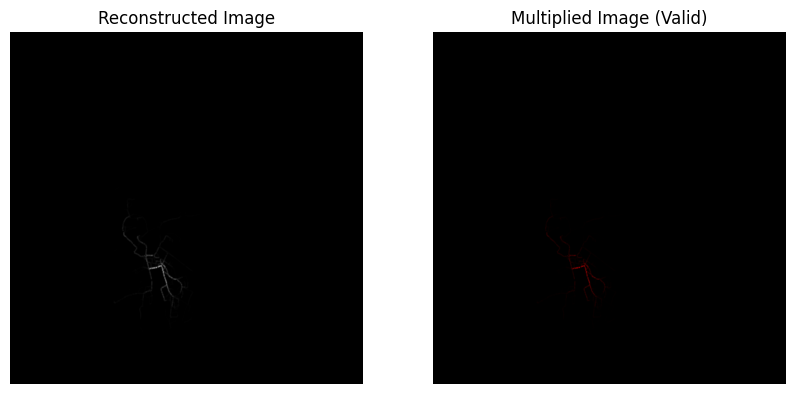

Compare reconstructed & invalid_extra
img1_array, img2_array (1754, 1172)


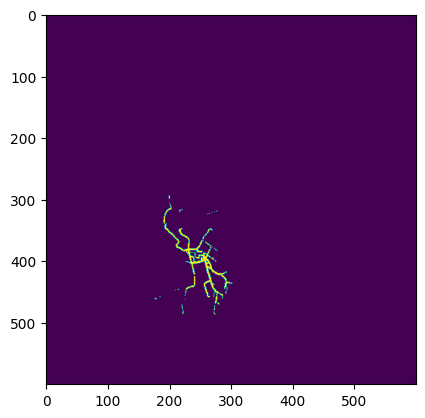

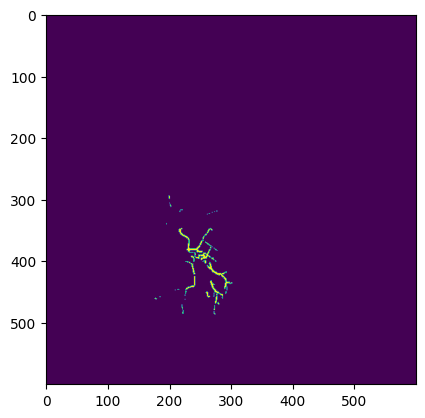

Index: 3269 perturbation 0
Percentage of similar pixels (ignoring black pixels): 66.82%
Novelty,tehát generátum az reconstructidhoz képest: 33.18%
Compare valid & valid_extra
img1_array, img2_array (1484, 990)


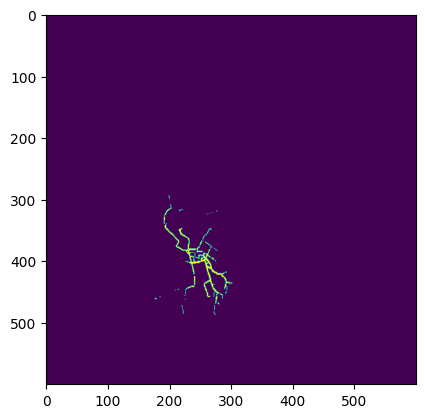

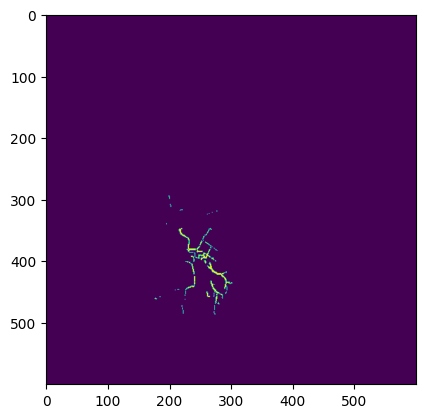

Percentage of similar pixels (ignoring black pixels): 66.71%
Validity + Novelty, tehát generált és helyes: 33.29%


In [39]:
#index = 10
# Fontos
for index in random_numbers:
    latent_space_images = generate_random_images_in_latent_space(model, route_dataset, image_index=index, epsilon=0.7, num_variations=3)
    images = find_most_similar_image(model, route_dataset, latent_space_images[0])
    valid = plot_multiplied_image(model, route_dataset, map_plot_tensor, latent_space_images[0])
    best_match_rgb = images[0]
    best_match = images[1]
    reconstructed = images[2]

    invalid_extra = reconstructed - best_match_rgb
    valid_extra = valid - best_match_rgb
    print(f"Compare reconstructed & invalid_extra")
    similarity_1 = compare_images(reconstructed, invalid_extra)
    novelty = 100-similarity_1
    print(f"Index: {index} perturbation 0")
    print(f'Percentage of similar pixels (ignoring black pixels): {similarity_1:.2f}%')
    print(f"Novelty,tehát generátum az reconstructidhoz képest: {novelty:.2f}%" )
      
    print(f"Compare valid & valid_extra")  
    similarity_2 = compare_images(valid, valid_extra)
    valid_and_novelty = 100-similarity_2
    print(f'Percentage of similar pixels (ignoring black pixels): {similarity_2:.2f}%')
    print(f"Validity + Novelty, tehát generált és helyes: {valid_and_novelty:.2f}%" )

In [31]:
import random

# Generate 10 random numbers between 0 and 4999, allowing duplicates
random_numbers = random.choices(range(5000), k=100)
print(random_numbers)

[703, 1348, 2585, 394, 251, 3974, 2878, 3964, 3747, 3398, 375, 208, 4335, 1587, 2182, 1237, 4346, 2737, 1805, 1328, 3878, 2281, 1688, 1382, 2873, 2166, 1245, 711, 422, 3363, 3629, 1714, 613, 324, 2589, 2667, 1853, 4837, 2675, 2340, 4606, 3694, 1371, 2739, 2865, 10, 1431, 1609, 3278, 1879, 2011, 976, 4290, 3593, 4593, 3947, 693, 612, 1845, 2709, 817, 4948, 2767, 4370, 1778, 2984, 1572, 2811, 682, 1403, 2386, 1192, 4390, 704, 2586, 4113, 2634, 272, 1120, 332, 2825, 1736, 2986, 4016, 3003, 4299, 2194, 3328, 4359, 1193, 1828, 4278, 2096, 3092, 4649, 4245, 3616, 2564, 848, 4900]


In [32]:
# Initialize lists to store the collected values
similarity_1_list = []
novelty_list = []
similarity_2_list = []
valid_and_novelty_list = []

for index in random_numbers:
    latent_space_images = generate_random_images_in_latent_space(model, route_dataset, image_index=index, epsilon=0.7, num_variations=3)
    images = find_most_similar_image(model, route_dataset, latent_space_images[0])
    valid = plot_multiplied_image(model, route_dataset, map_plot_tensor, latent_space_images[0])
    best_match_rgb = images[0]
    best_match = images[1]
    reconstructed = images[2]

    invalid_extra = reconstructed - best_match_rgb
    valid_extra = valid - best_match_rgb

    # Compare reconstructed & invalid_extra
    similarity_1 = compare_images(reconstructed, invalid_extra)
    novelty = 100 - similarity_1
    similarity_1_list.append(similarity_1)
    novelty_list.append(novelty)
    print(f"Index: {index} perturbation 0")
    print(f'Percentage of similar pixels (ignoring black pixels): {similarity_1:.2f}%')
    print(f"Novelty, tehát generátum az reconstructidhoz képest: {novelty:.2f}%")

    # Compare valid & valid_extra
    similarity_2 = compare_images(valid, valid_extra)
    valid_and_novelty = 100 - similarity_2
    similarity_2_list.append(similarity_2)
    valid_and_novelty_list.append(valid_and_novelty)
    print(f'Percentage of similar pixels (ignoring black pixels): {similarity_2:.2f}%')
    print(f"Validity + Novelty, tehát generált és helyes: {valid_and_novelty:.2f}%")

# Calculate averages
avg_similarity_1 = sum(similarity_1_list) / len(similarity_1_list) if similarity_1_list else 0
avg_novelty = sum(novelty_list) / len(novelty_list) if novelty_list else 0
avg_similarity_2 = sum(similarity_2_list) / len(similarity_2_list) if similarity_2_list else 0
avg_valid_and_novelty = sum(valid_and_novelty_list) / len(valid_and_novelty_list) if valid_and_novelty_list else 0

# Print averages
print("\n--- Averages ---")
print(f"Average Similarity 1 (reconstructed vs invalid_extra): {avg_similarity_1:.2f}%")
print(f"Average Novelty: {avg_novelty:.2f}%")
print(f"Average Similarity 2 (valid vs valid_extra): {avg_similarity_2:.2f}%")
print(f"Average Validity + Novelty: {avg_valid_and_novelty:.2f}%")


Most similar image percentage of white pixels preserved: 31.76%
Index: 703 perturbation 0
Percentage of similar pixels (ignoring black pixels): 68.29%
Novelty, tehát generátum az reconstructidhoz képest: 31.71%
Percentage of similar pixels (ignoring black pixels): 67.30%
Validity + Novelty, tehát generált és helyes: 32.70%
Most similar image percentage of white pixels preserved: 55.48%
Index: 1348 perturbation 0
Percentage of similar pixels (ignoring black pixels): 54.92%
Novelty, tehát generátum az reconstructidhoz képest: 45.08%
Percentage of similar pixels (ignoring black pixels): 45.70%
Validity + Novelty, tehát generált és helyes: 54.30%
Most similar image percentage of white pixels preserved: 69.20%
Index: 2585 perturbation 0
Percentage of similar pixels (ignoring black pixels): 59.05%
Novelty, tehát generátum az reconstructidhoz képest: 40.95%
Percentage of similar pixels (ignoring black pixels): 39.86%
Validity + Novelty, tehát generált és helyes: 60.14%
Most similar image perc